# Run run_1peat_opti

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xskillscore as xs
import calendar
import os

In [2]:
site = 'tvc'
site_longname = 'Trail Valley Creak, northwestern Canada'
y_start = 2013
y_end = 2019

labels = [
    # '1peat_30min_ext', 
    # '1peat_DEF', 
    # '1peat_BUG_CORRECT_TSNBT_OP1_EZERO',
    # '1peat_PHYS_ALL_SUBLI_CORRECT',
    # '1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC',
    '1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne',
    '1peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne',
    '1peat_Snowf',
    '1peat_2xSnowf', # not x2 but 1.5 in this notebook
]

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [3]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref_30min_ext.nc')

In [4]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [5]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

## Convert noleap year cftime to datetime

In [6]:
ds_d_list[i].time

<xarray.DataArray 'time' (time: 2555)> Size: 20kB
array([cftime.DatetimeNoLeap(2013, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2019, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 20kB 2013-01-01 00:00:00 ... 2019-12-31 00:00:00
Attributes:
    long_name:  time

In [7]:
import cftime
for i in range(len(labels)):
    if isinstance(ds_d_list[i]['time'].values[0], cftime.DatetimeNoLeap):
        ds_d_list[i]['time'] = pd.to_datetime(ds_d_list[i].indexes['time'].to_datetimeindex())

/tmp/ipykernel_294982/1930742035.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_list[i]['time'] = pd.to_datetime(ds_d_list[i].indexes['time'].to_datetimeindex())
/tmp/ipykernel_294982/1930742035.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_list[i]['time'] = pd.to_datetime(ds_d_list[i].indexes['time'].to_datetimeindex())
/tmp/ipykernel_294982/1930742035.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtl

In [8]:
ds_d_list[i].time

<xarray.DataArray 'time' (time: 2555)> Size: 20kB
array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000',
       '2013-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31

Text(0.5, 0.98, 'Trail Valley Creak, northwestern Canada')

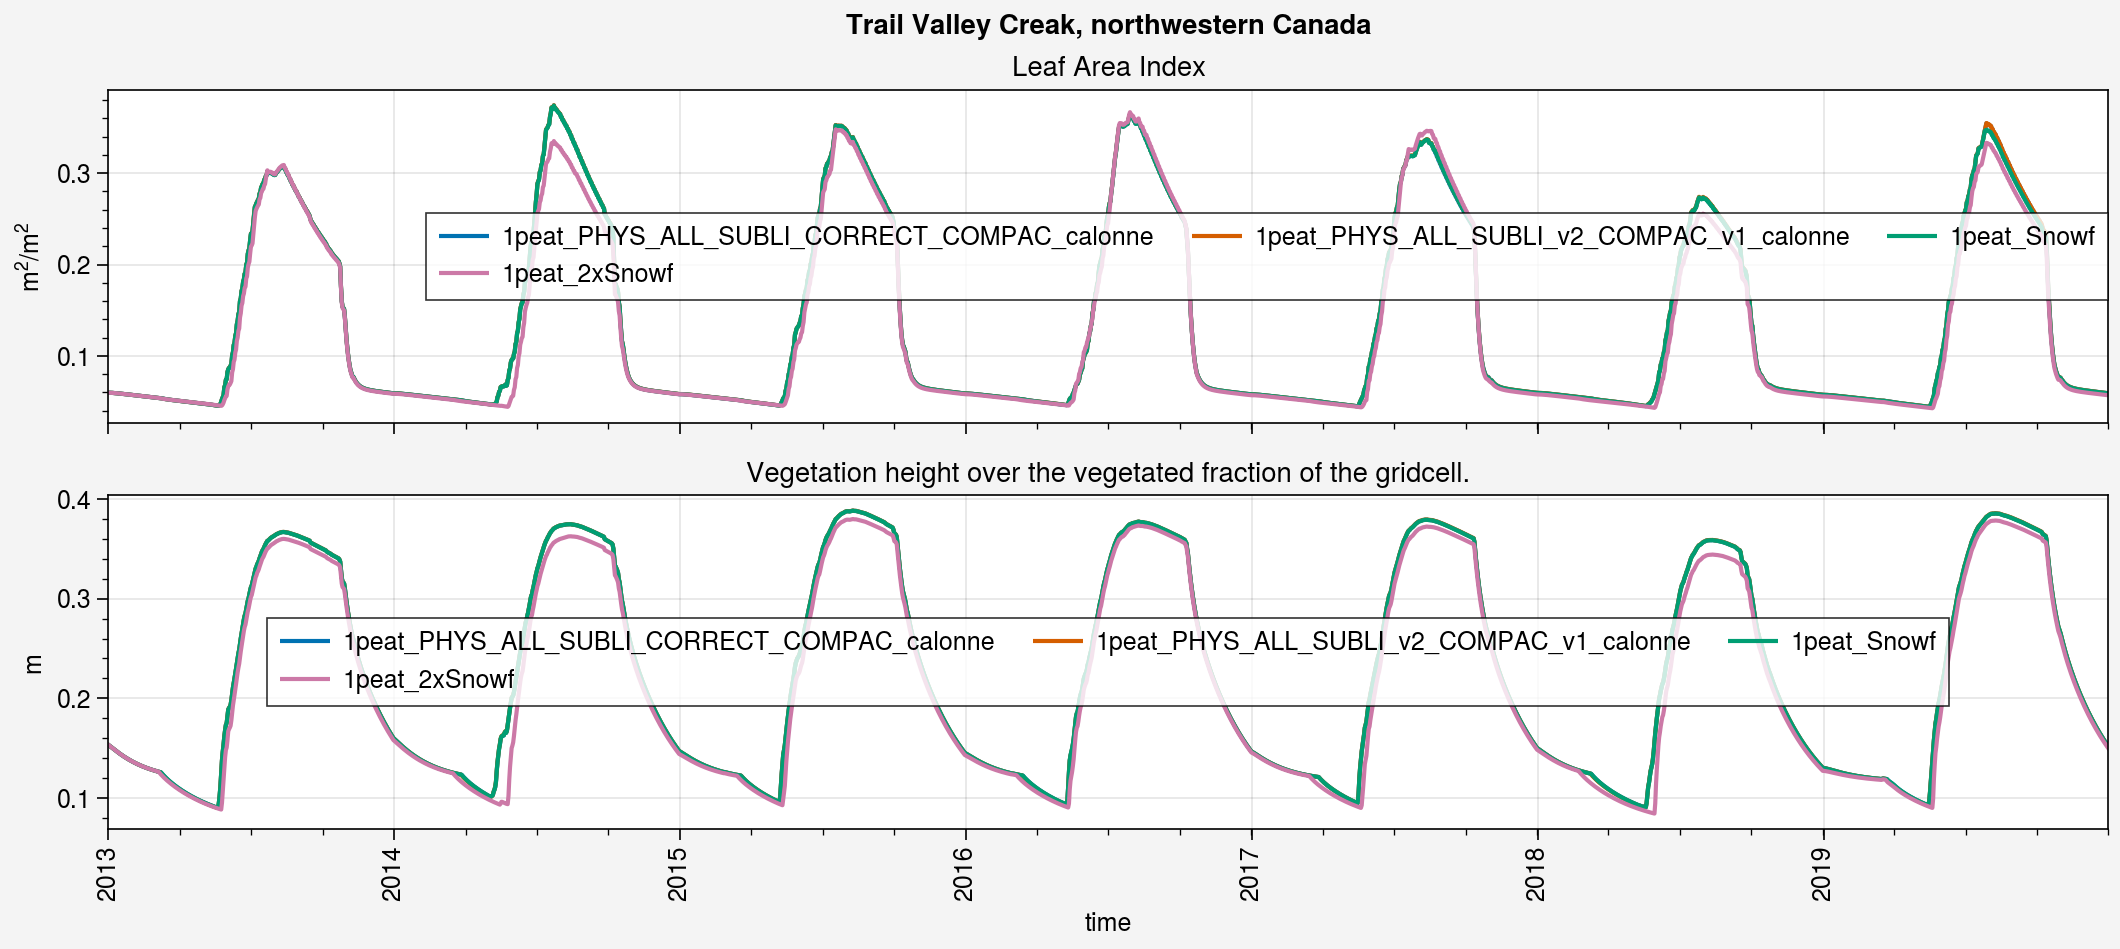

In [9]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Trail Valley Creak, northwestern Canada (2013-2019)')

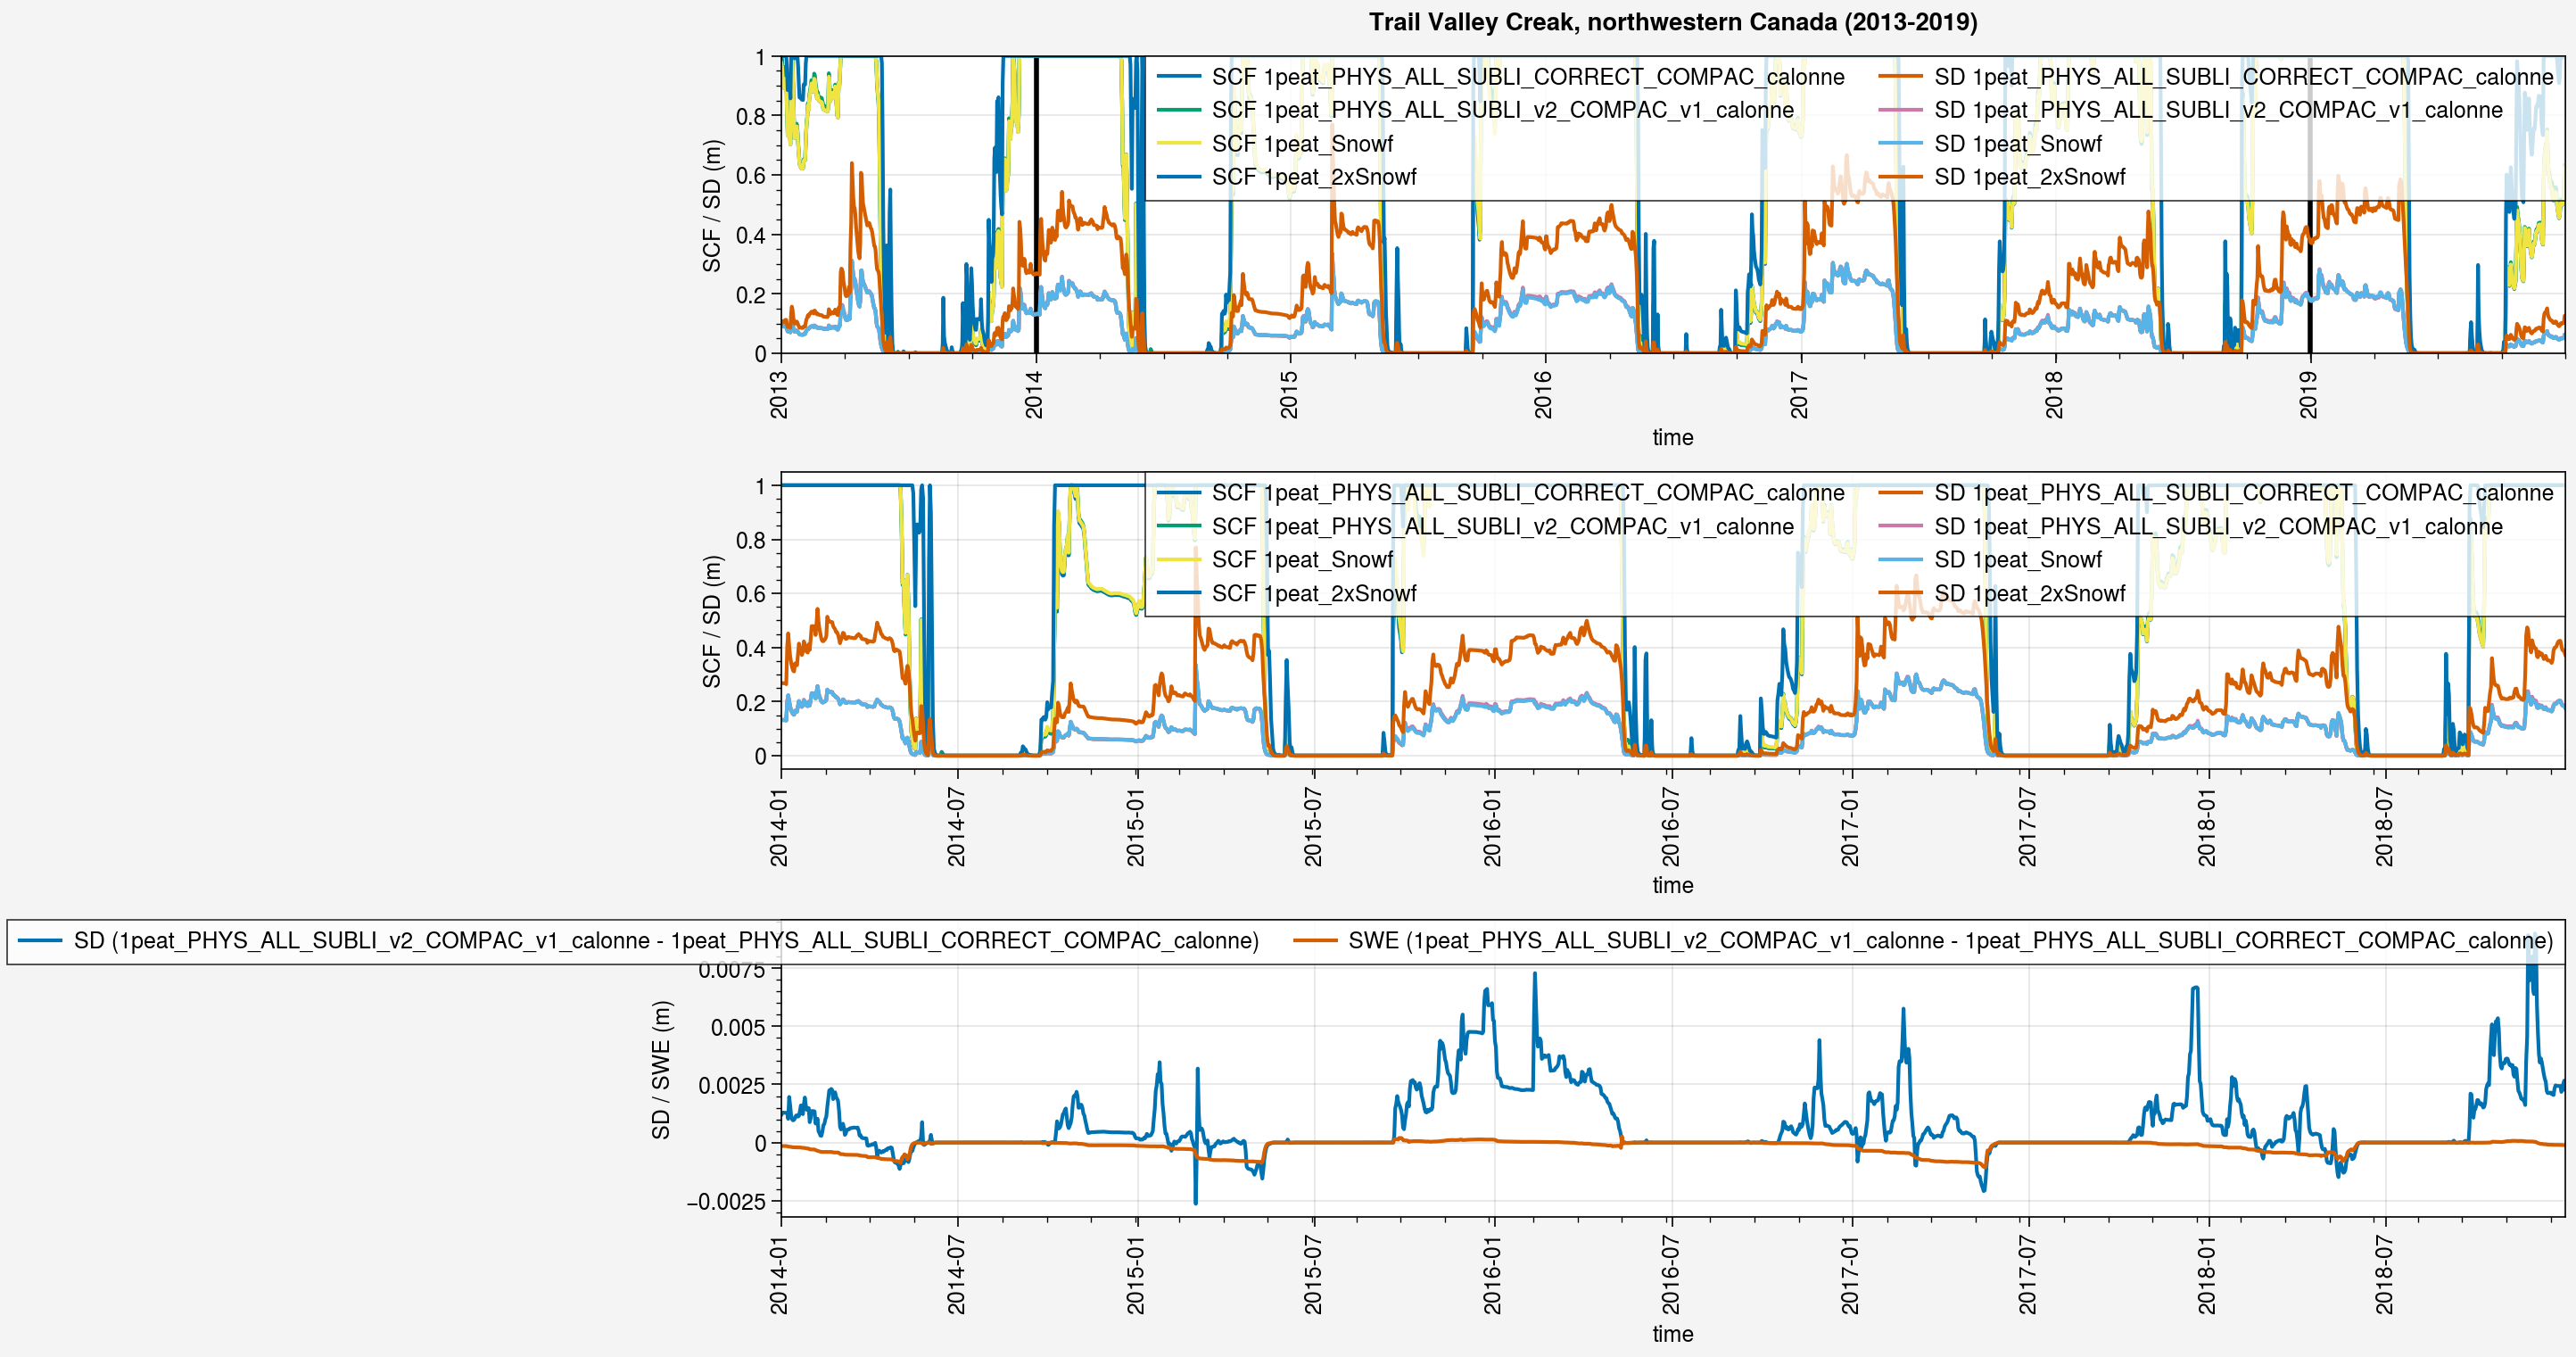

In [10]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+1)
end = str(y_end-1)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


Text(0.5, 0.98, 'Trail Valley Creak, northwestern Canada (2013-2019)')

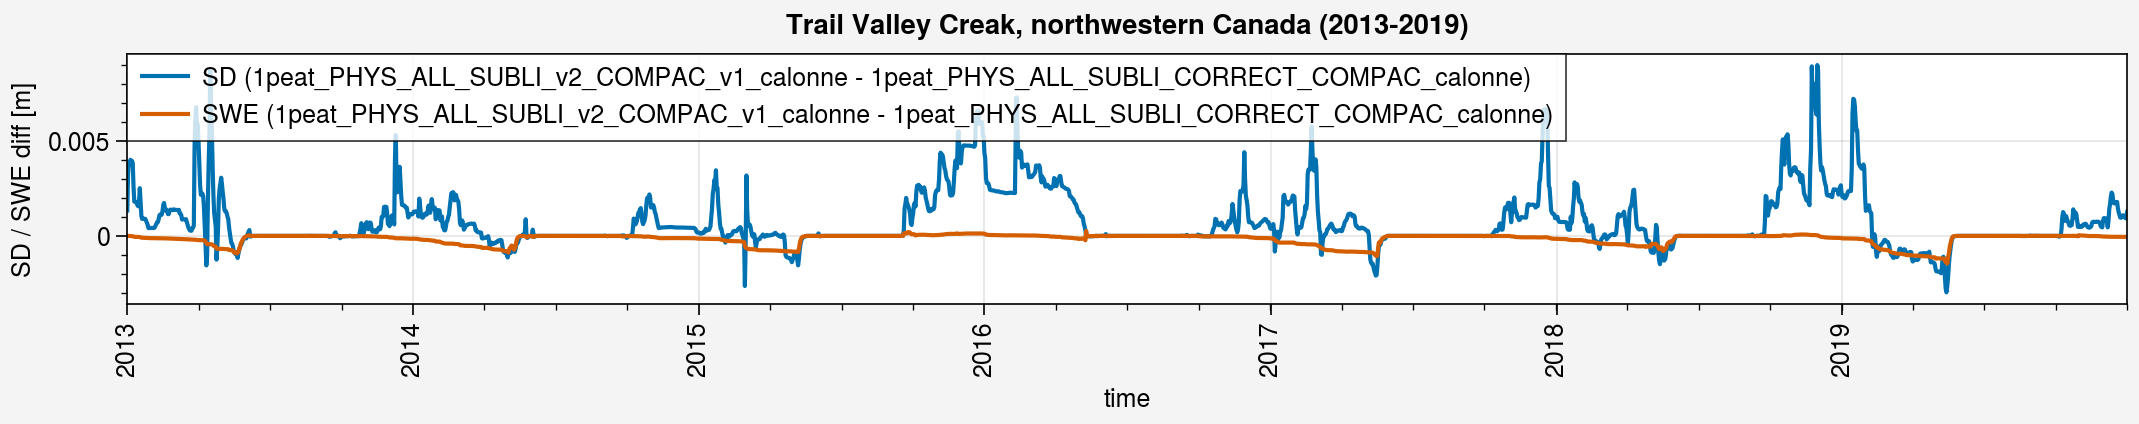

In [11]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=8, refwidth=10, share=0)

start = str(y_start)
end = str(y_end)

axs[0].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
axs[0].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')

axs[0].legend(ncols=1)
axs[0].format(
    ylabel='SD / SWE diff [m]'
)

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')
# fig.save('img/byl_mtr_SUBLI_diff.jpg')

## Compare with obs

In [12]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/TVC/TVCSnowCLM/TVCMetData'
ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_tvc_2017_2019.nc')
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_d_obs['snd_auto'] = ds_d_obs.snd_auto/100
ds_d_obs = ds_d_obs.rename({'albedo': 'albs', 'swc': 'mrsll'})
ds_d_obs

<xarray.Dataset> Size: 112kB
Dimensions:           (time: 668, sdepth: 4)
Coordinates:
  * sdepth            (sdepth) float64 32B 0.02 0.05 0.1 0.2
  * time              (time) datetime64[ns] 5kB 2017-09-01 ... 2019-06-30
Data variables: (12/14)
    snd_auto          (time) float64 5kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tsl               (time, sdepth) float64 21kB 5.021 3.834 ... 5.732 4.72
    mrsll             (time, sdepth) float64 21kB 0.232 0.1819 ... 0.287 0.433
    SoilHEatFlux_org  (time) float64 5kB 6.104 11.39 9.86 1.357 ... nan nan nan
    SoilHEatFlux_min  (time) float64 5kB 5.848 12.86 11.75 7.613 ... nan nan nan
    NEE_filt          (time) float64 5kB -0.8253 0.1094 0.406 ... -2.071 -0.0614
    ...                ...
    NEE_filled        (time) float64 5kB 0.152 0.6982 0.6329 ... -1.871 -0.0614
    LE_filled         (time) float64 5kB 22.29 16.89 21.12 ... 32.07 27.5 -1.015
    H_filled          (time) float64 5kB 17.54 12.97 17.06 ... 78.96 -12.94
    CH4_filt          (time) float64 5kB 0.001279 0.001616 0.002003 ... nan nan
    CH4_filled        (time) float64 5kB 0.001136 0.001072 ... 0.0002559
    albs              (time) float64 5kB 0.1721 0.1551 0.209 ... 0.225 0.331
Attributes:
    location:    Trail Valley Creak
    ref:         https://doi.org/10.5194/tc-16-4201-2022
    soil_ref:    https://doi.pangaea.de/10.1594/PANGAEA.962726
    downloaded:  13/10/2024 by Mickaël Lalande
    merge:       TVCSnowCLM/TVCMetData/MSC_Snowdepth.csv and TVC_CLASSIC_2013...

### SD

In [13]:
y_start_obs = 2017

tot_year = y_end - y_start_obs + 1
gap = 3
years = pplt.arange(y_start_obs, y_end)
years

array([2017, 2018, 2019])

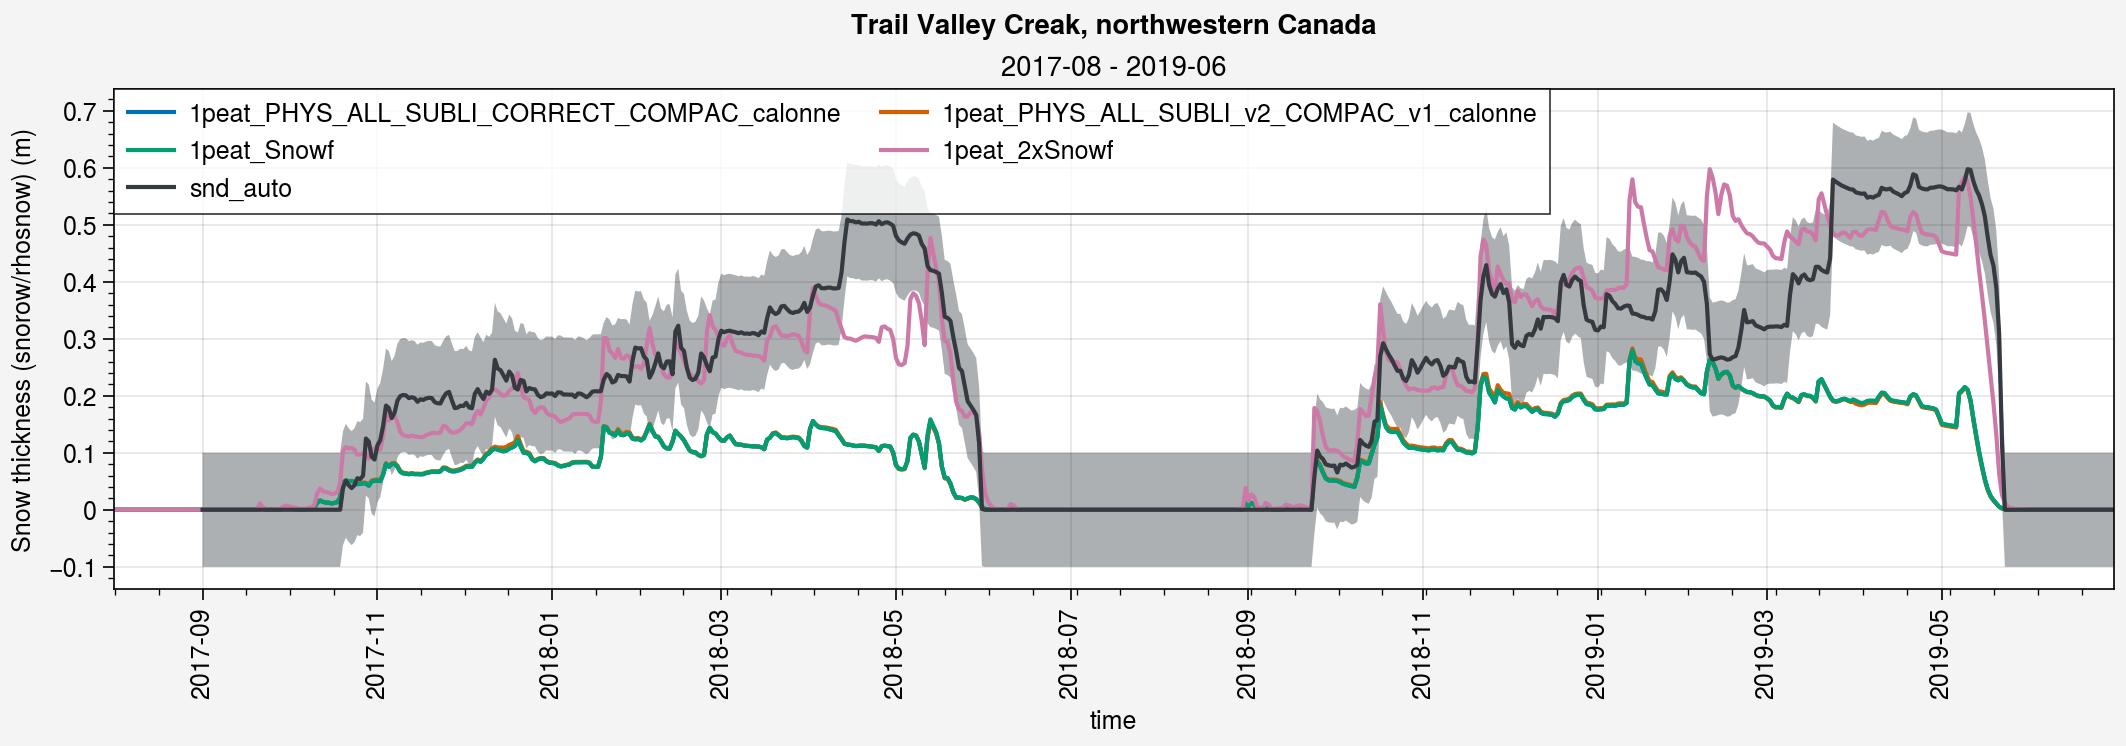

In [14]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-06')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-06')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)    

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


### SWE

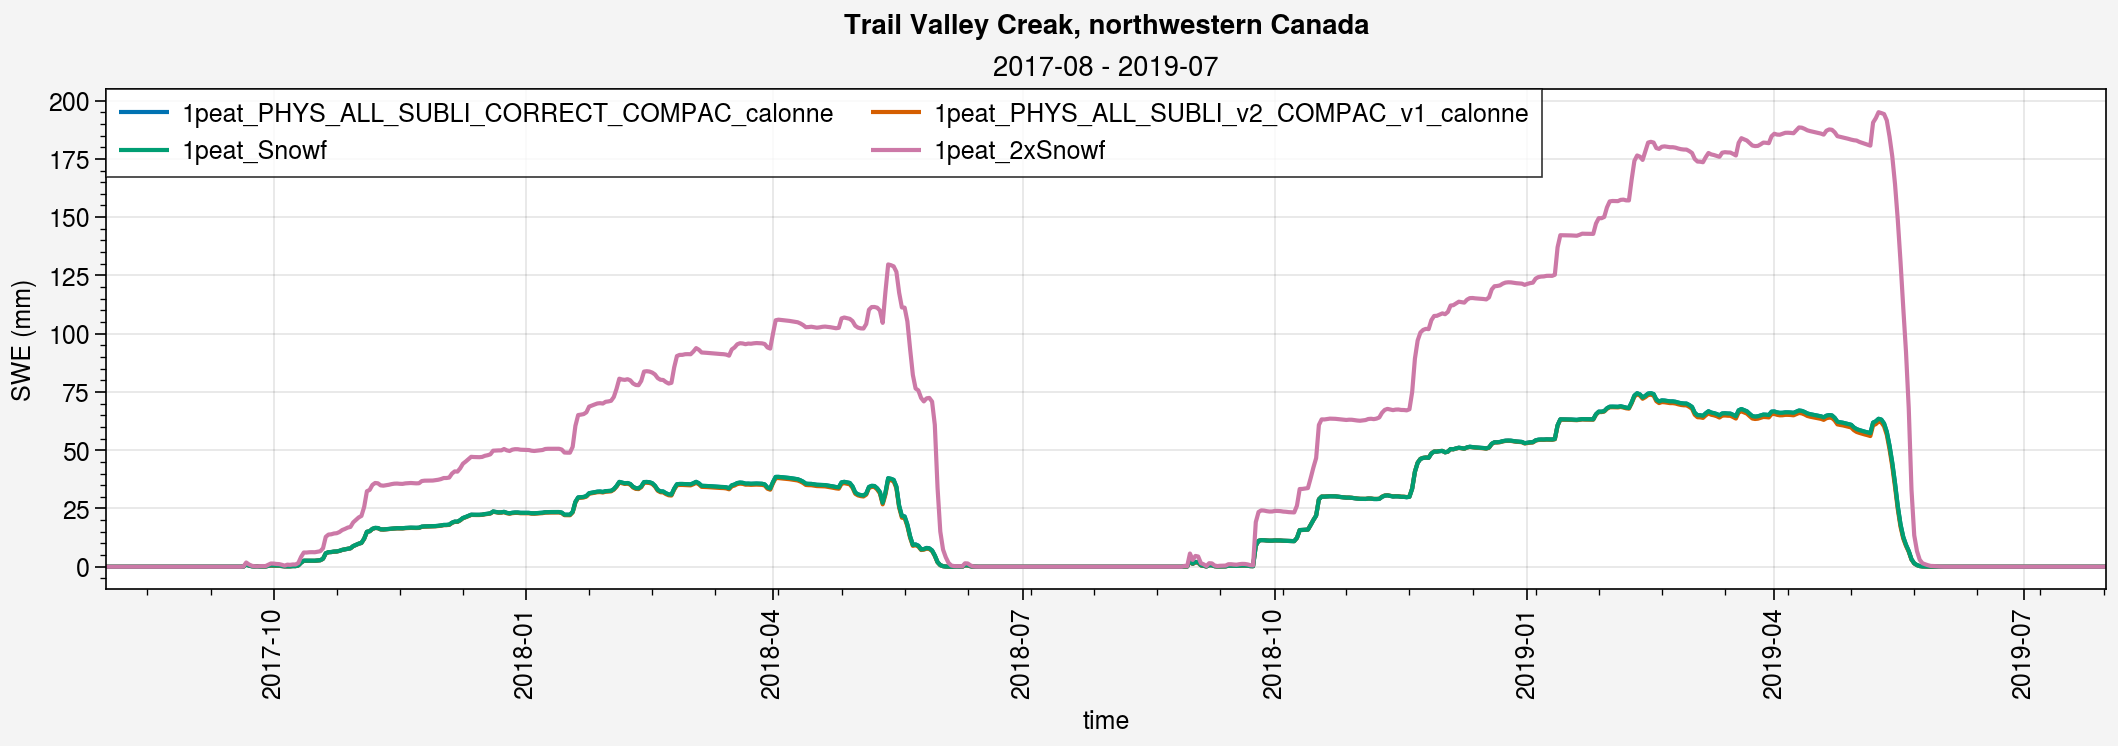

In [15]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

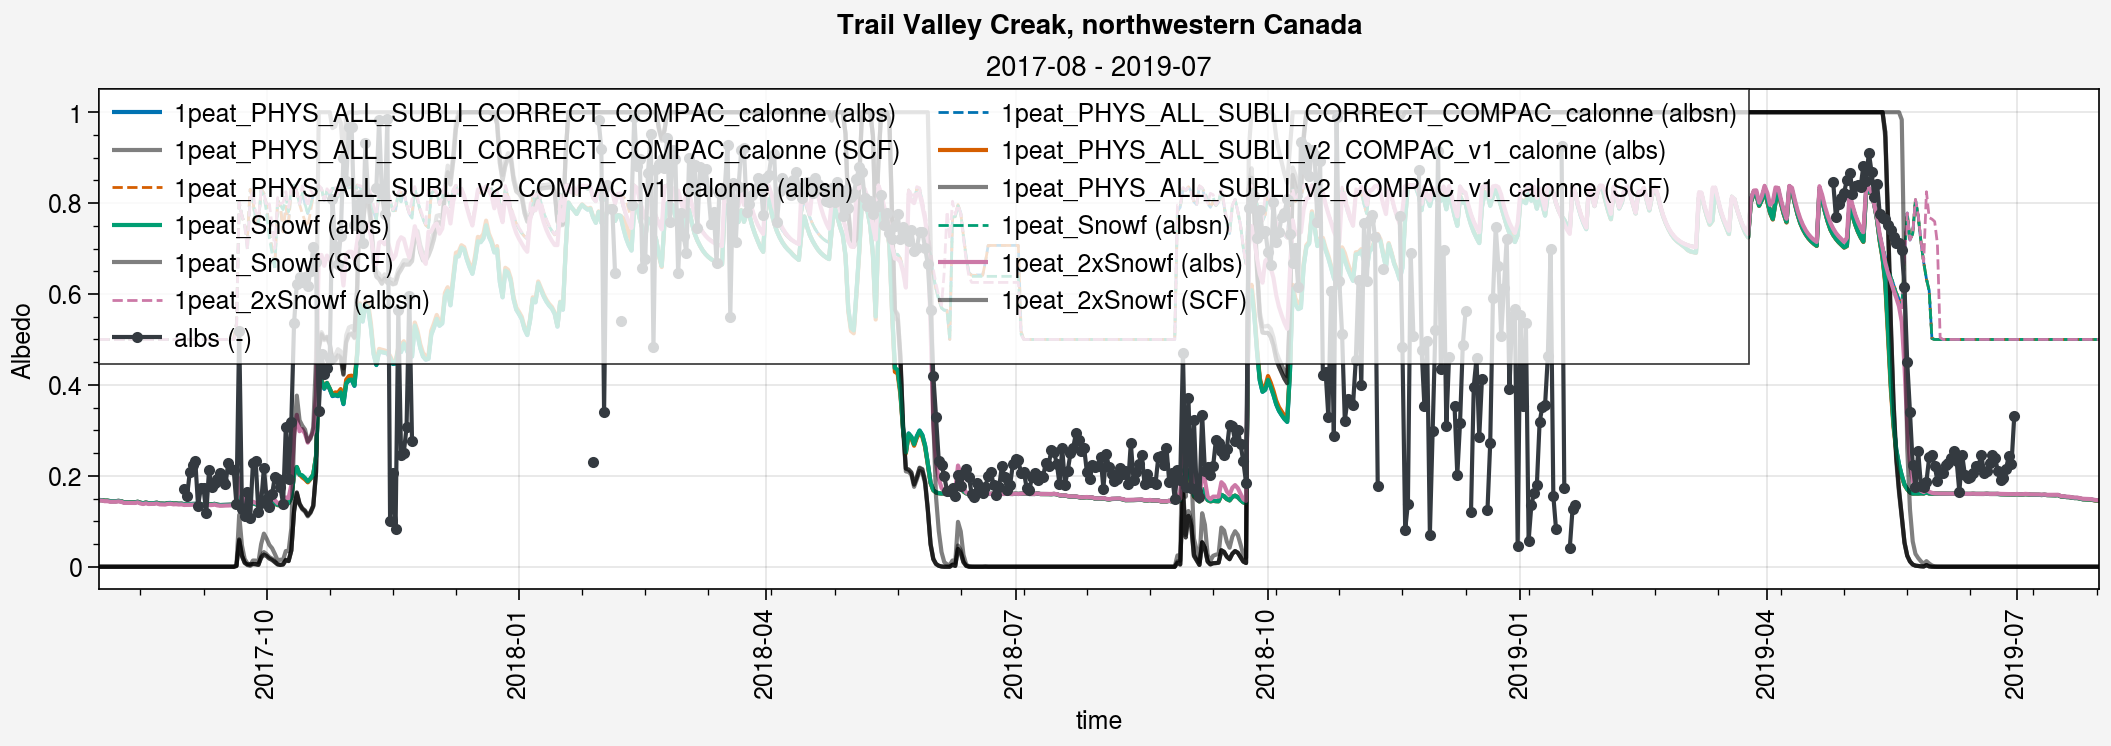

In [16]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1
    
    # Obs
    axs[0].plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
    fig.suptitle(site_longname)


### Surface Temperature

Domine et al. ([2019](https://onlinelibrary.wiley.com/doi/abs/10.1029/2018MS001445)): "**Averaged over a period of several days the surface temperatures are essentially the same**. The amplitude variations are greater in the Alpine snowpack (Figure 8b) because the insulating layer at the top does not allow damping the air temperature variations by heat exchanges with the snowpack. This effect is more important in April and May, when daily temperature variations reach 20 °C, sometimes more. The absolute temperature differences reaches 4.7 °C on 8 February, when the temperature suddenly increases by 15 °C in 5 hr, and the surface temperature of the Alpine snowpack increases more rapidly."

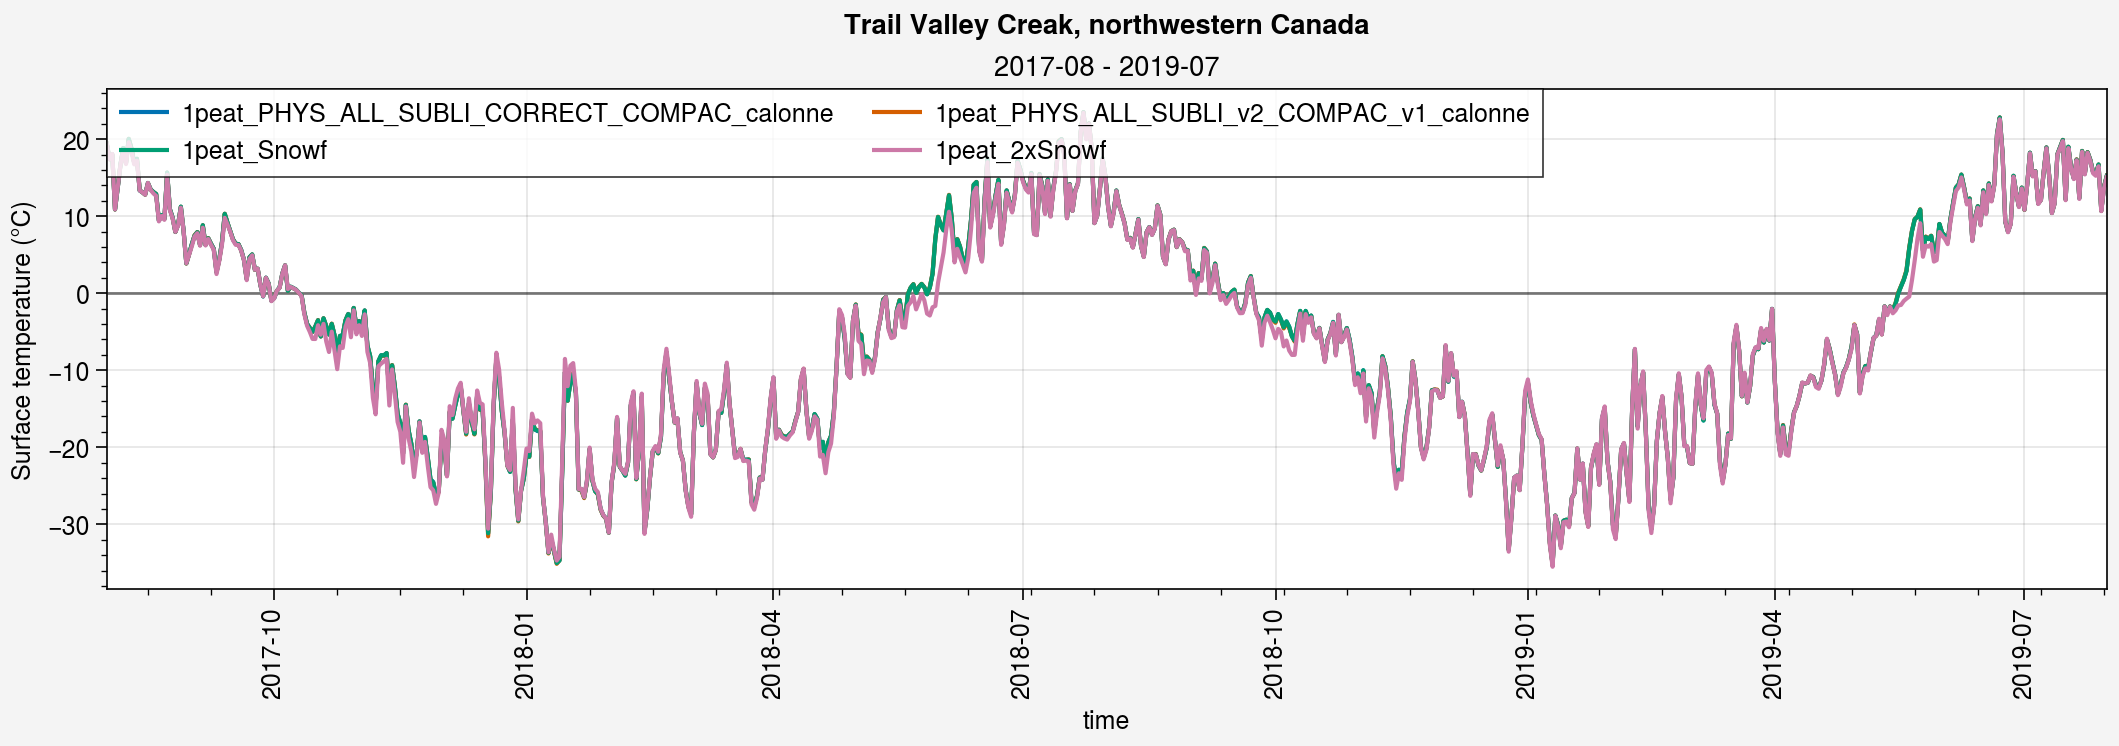

In [17]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)
    
    # Obs
    # axs[0].plot(ds_d_obs.ts.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

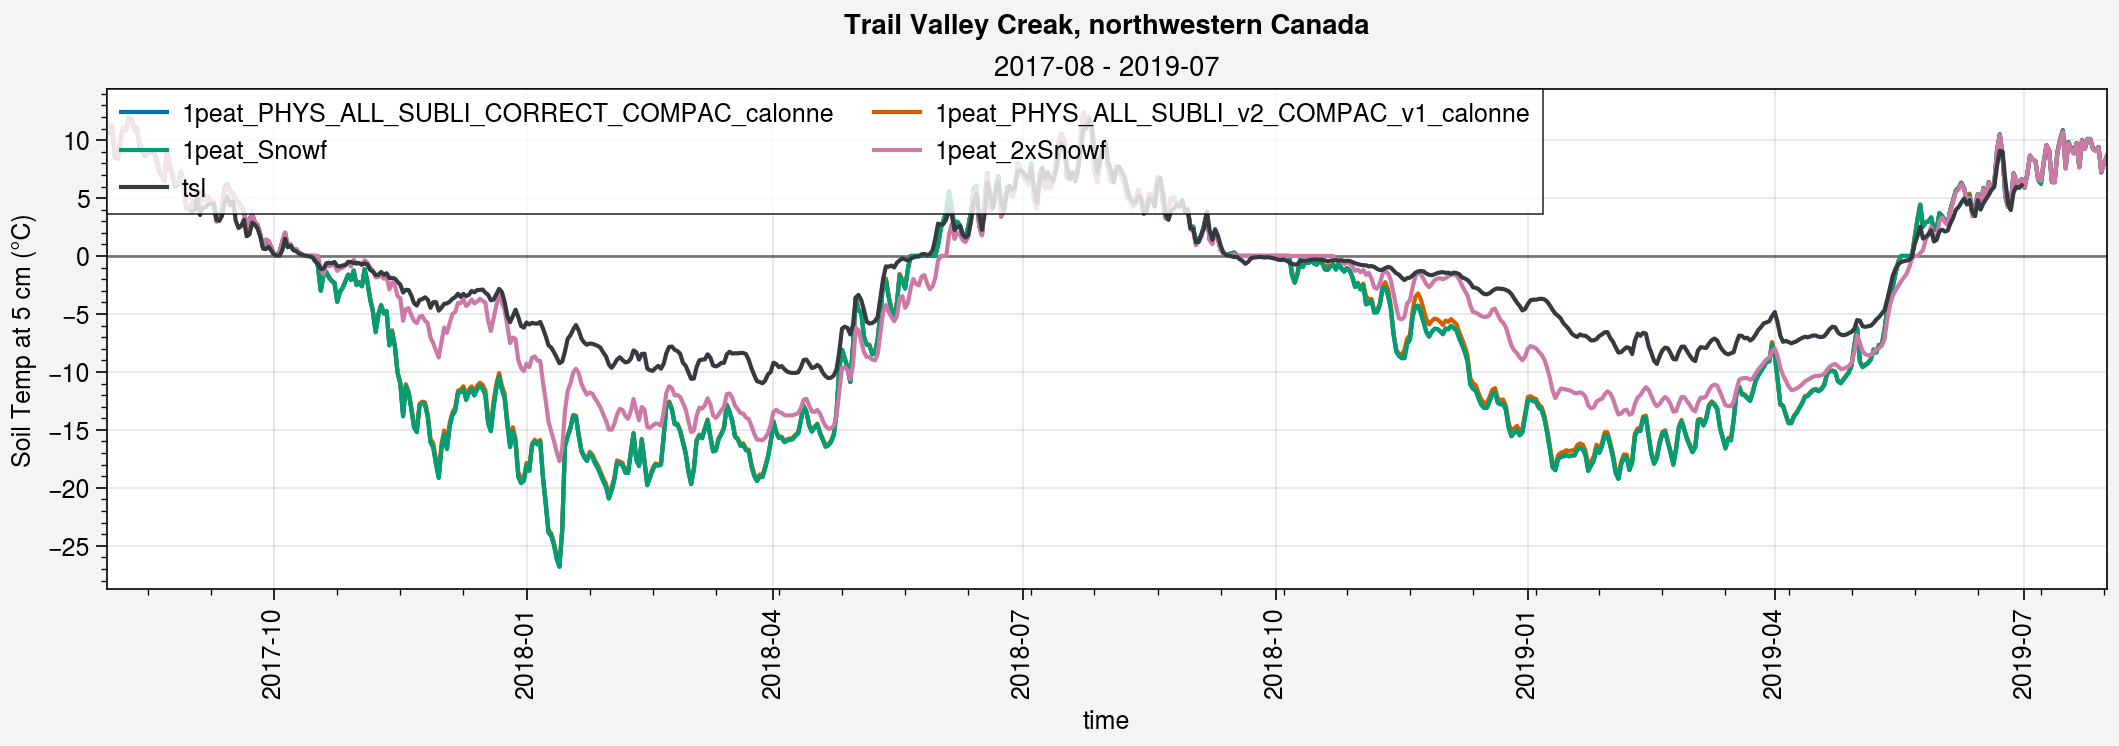

In [18]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=sdepth)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    axs[0].plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


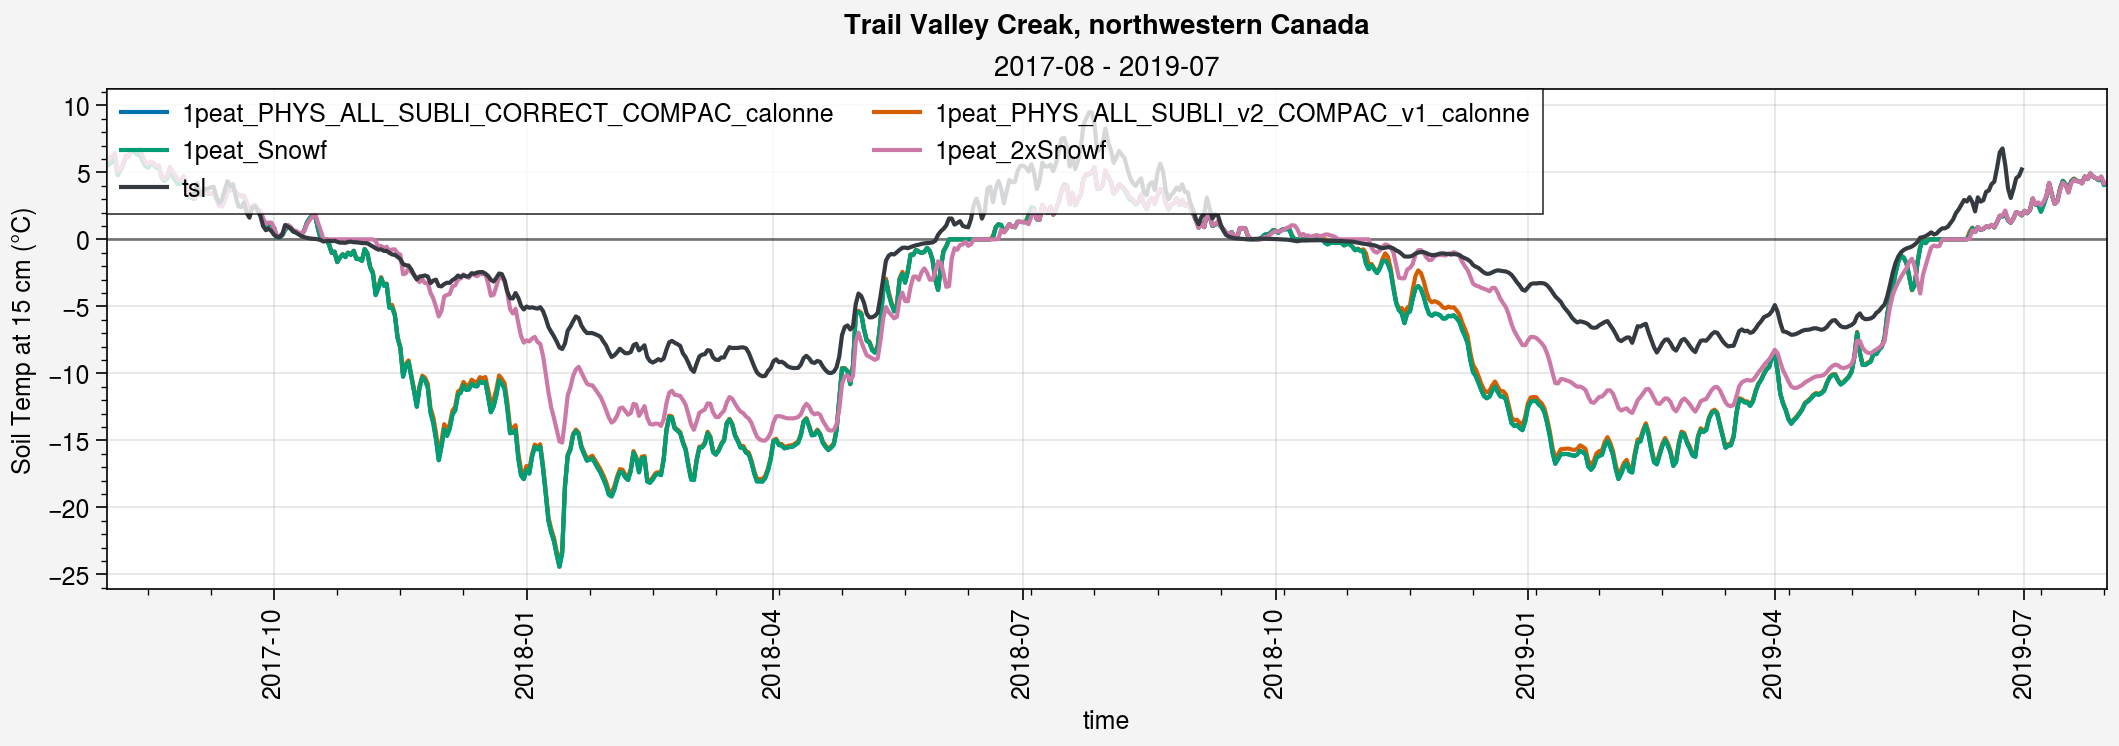

In [19]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=sdepth)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    axs[0].plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


### Volumetric water content

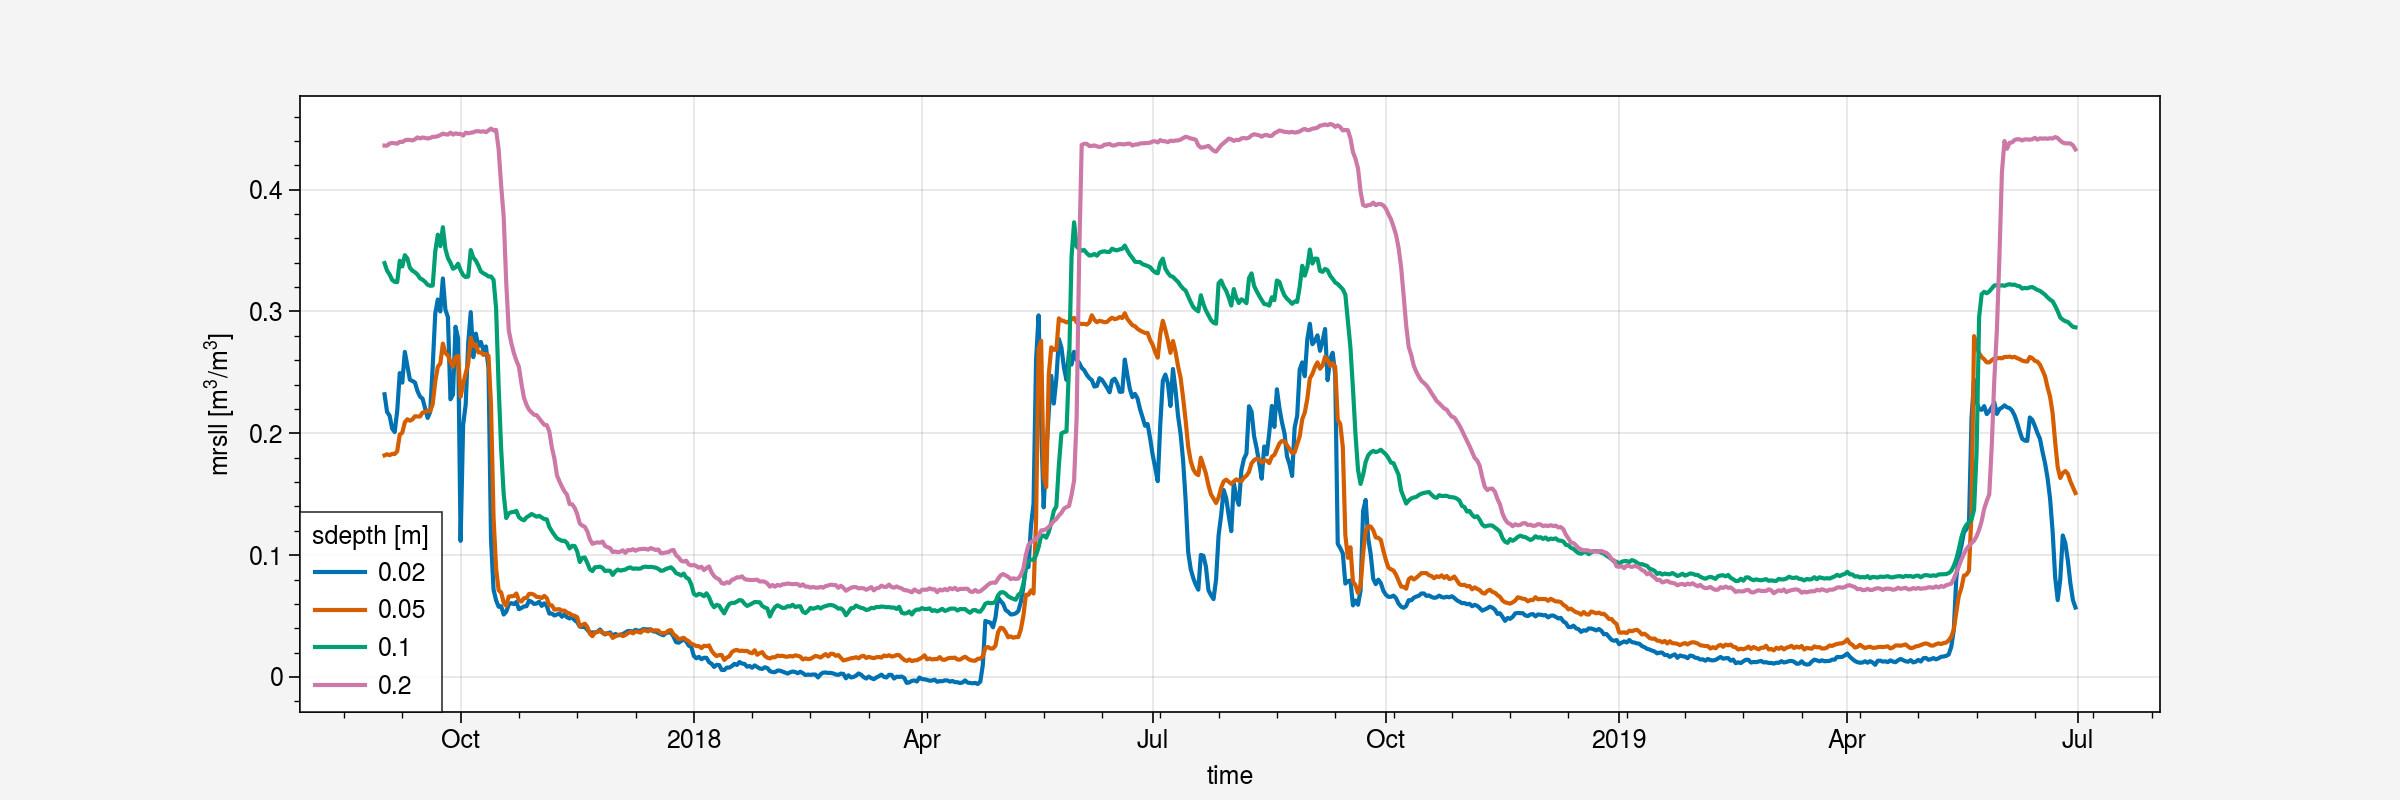

In [20]:
%matplotlib inline
ds_d_obs.mrsll.plot(hue='sdepth', figsize=(12, 4))

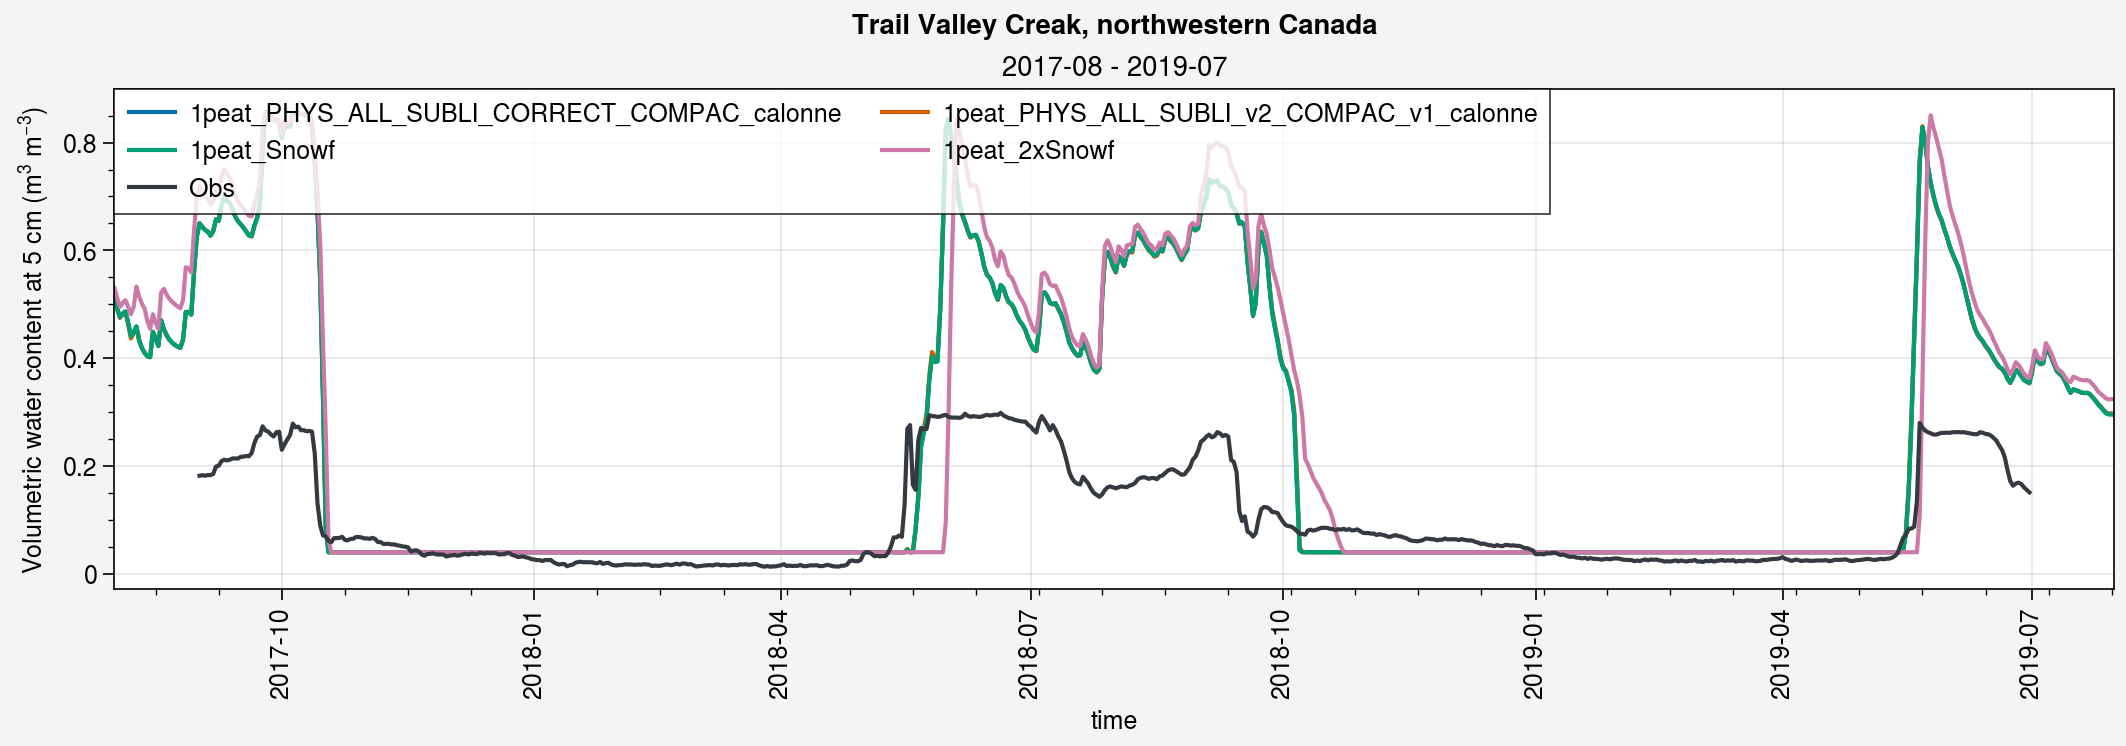

In [21]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


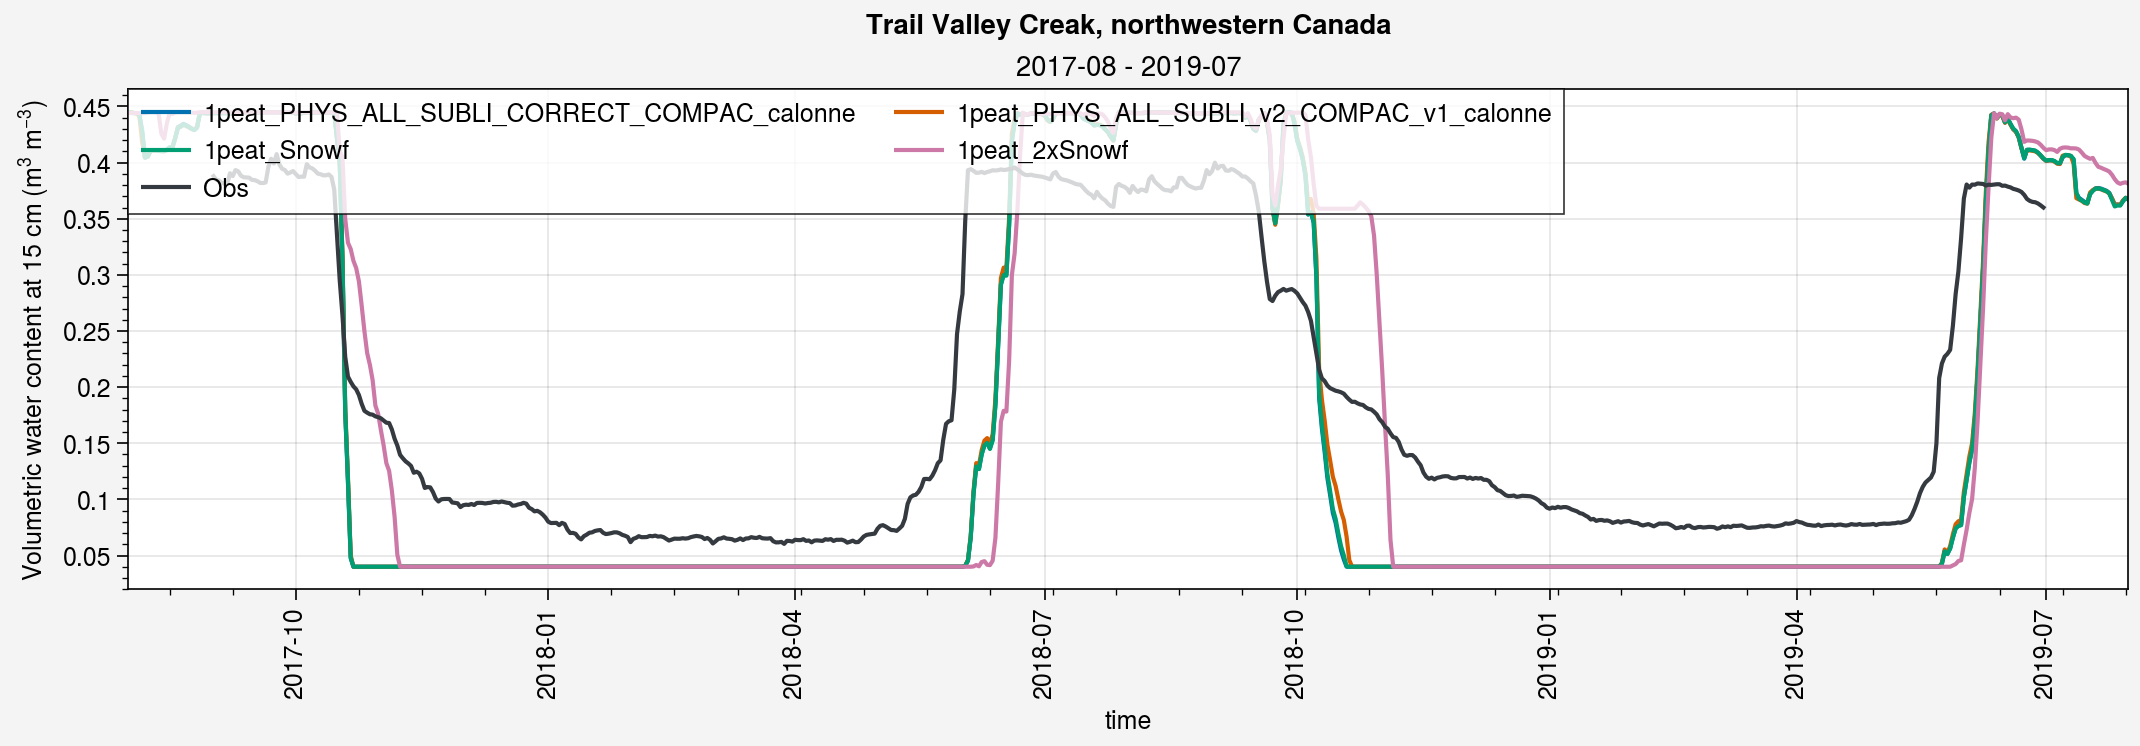

In [22]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


### Thermal conductivity

<a list of 1 Line2D objects>

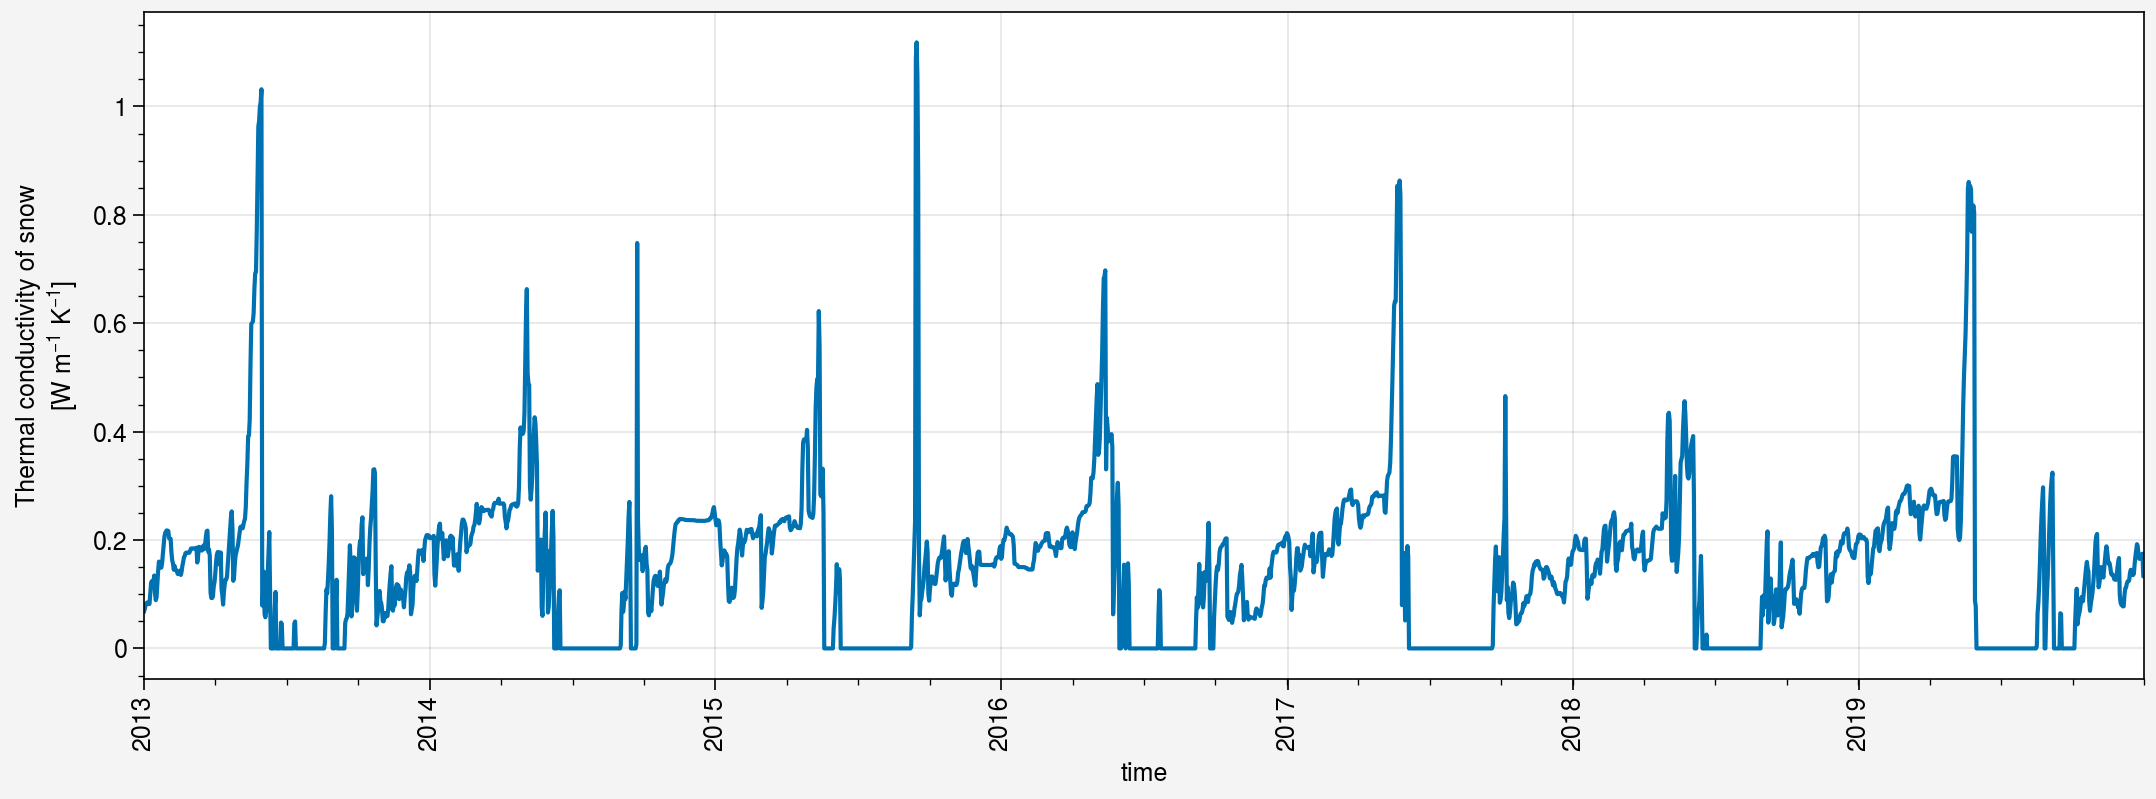

In [23]:
%matplotlib inline
fig, axs = pplt.subplots(refwidth=10, refaspect=3)
# ds_obs_tc.tcs.plot(hue='sheight')
ds_d_list[1].tcsnow.plot()

## All 

In [24]:
period

slice('2017-08', '2019-07', None)

In [25]:
import warnings
warnings.filterwarnings("ignore")

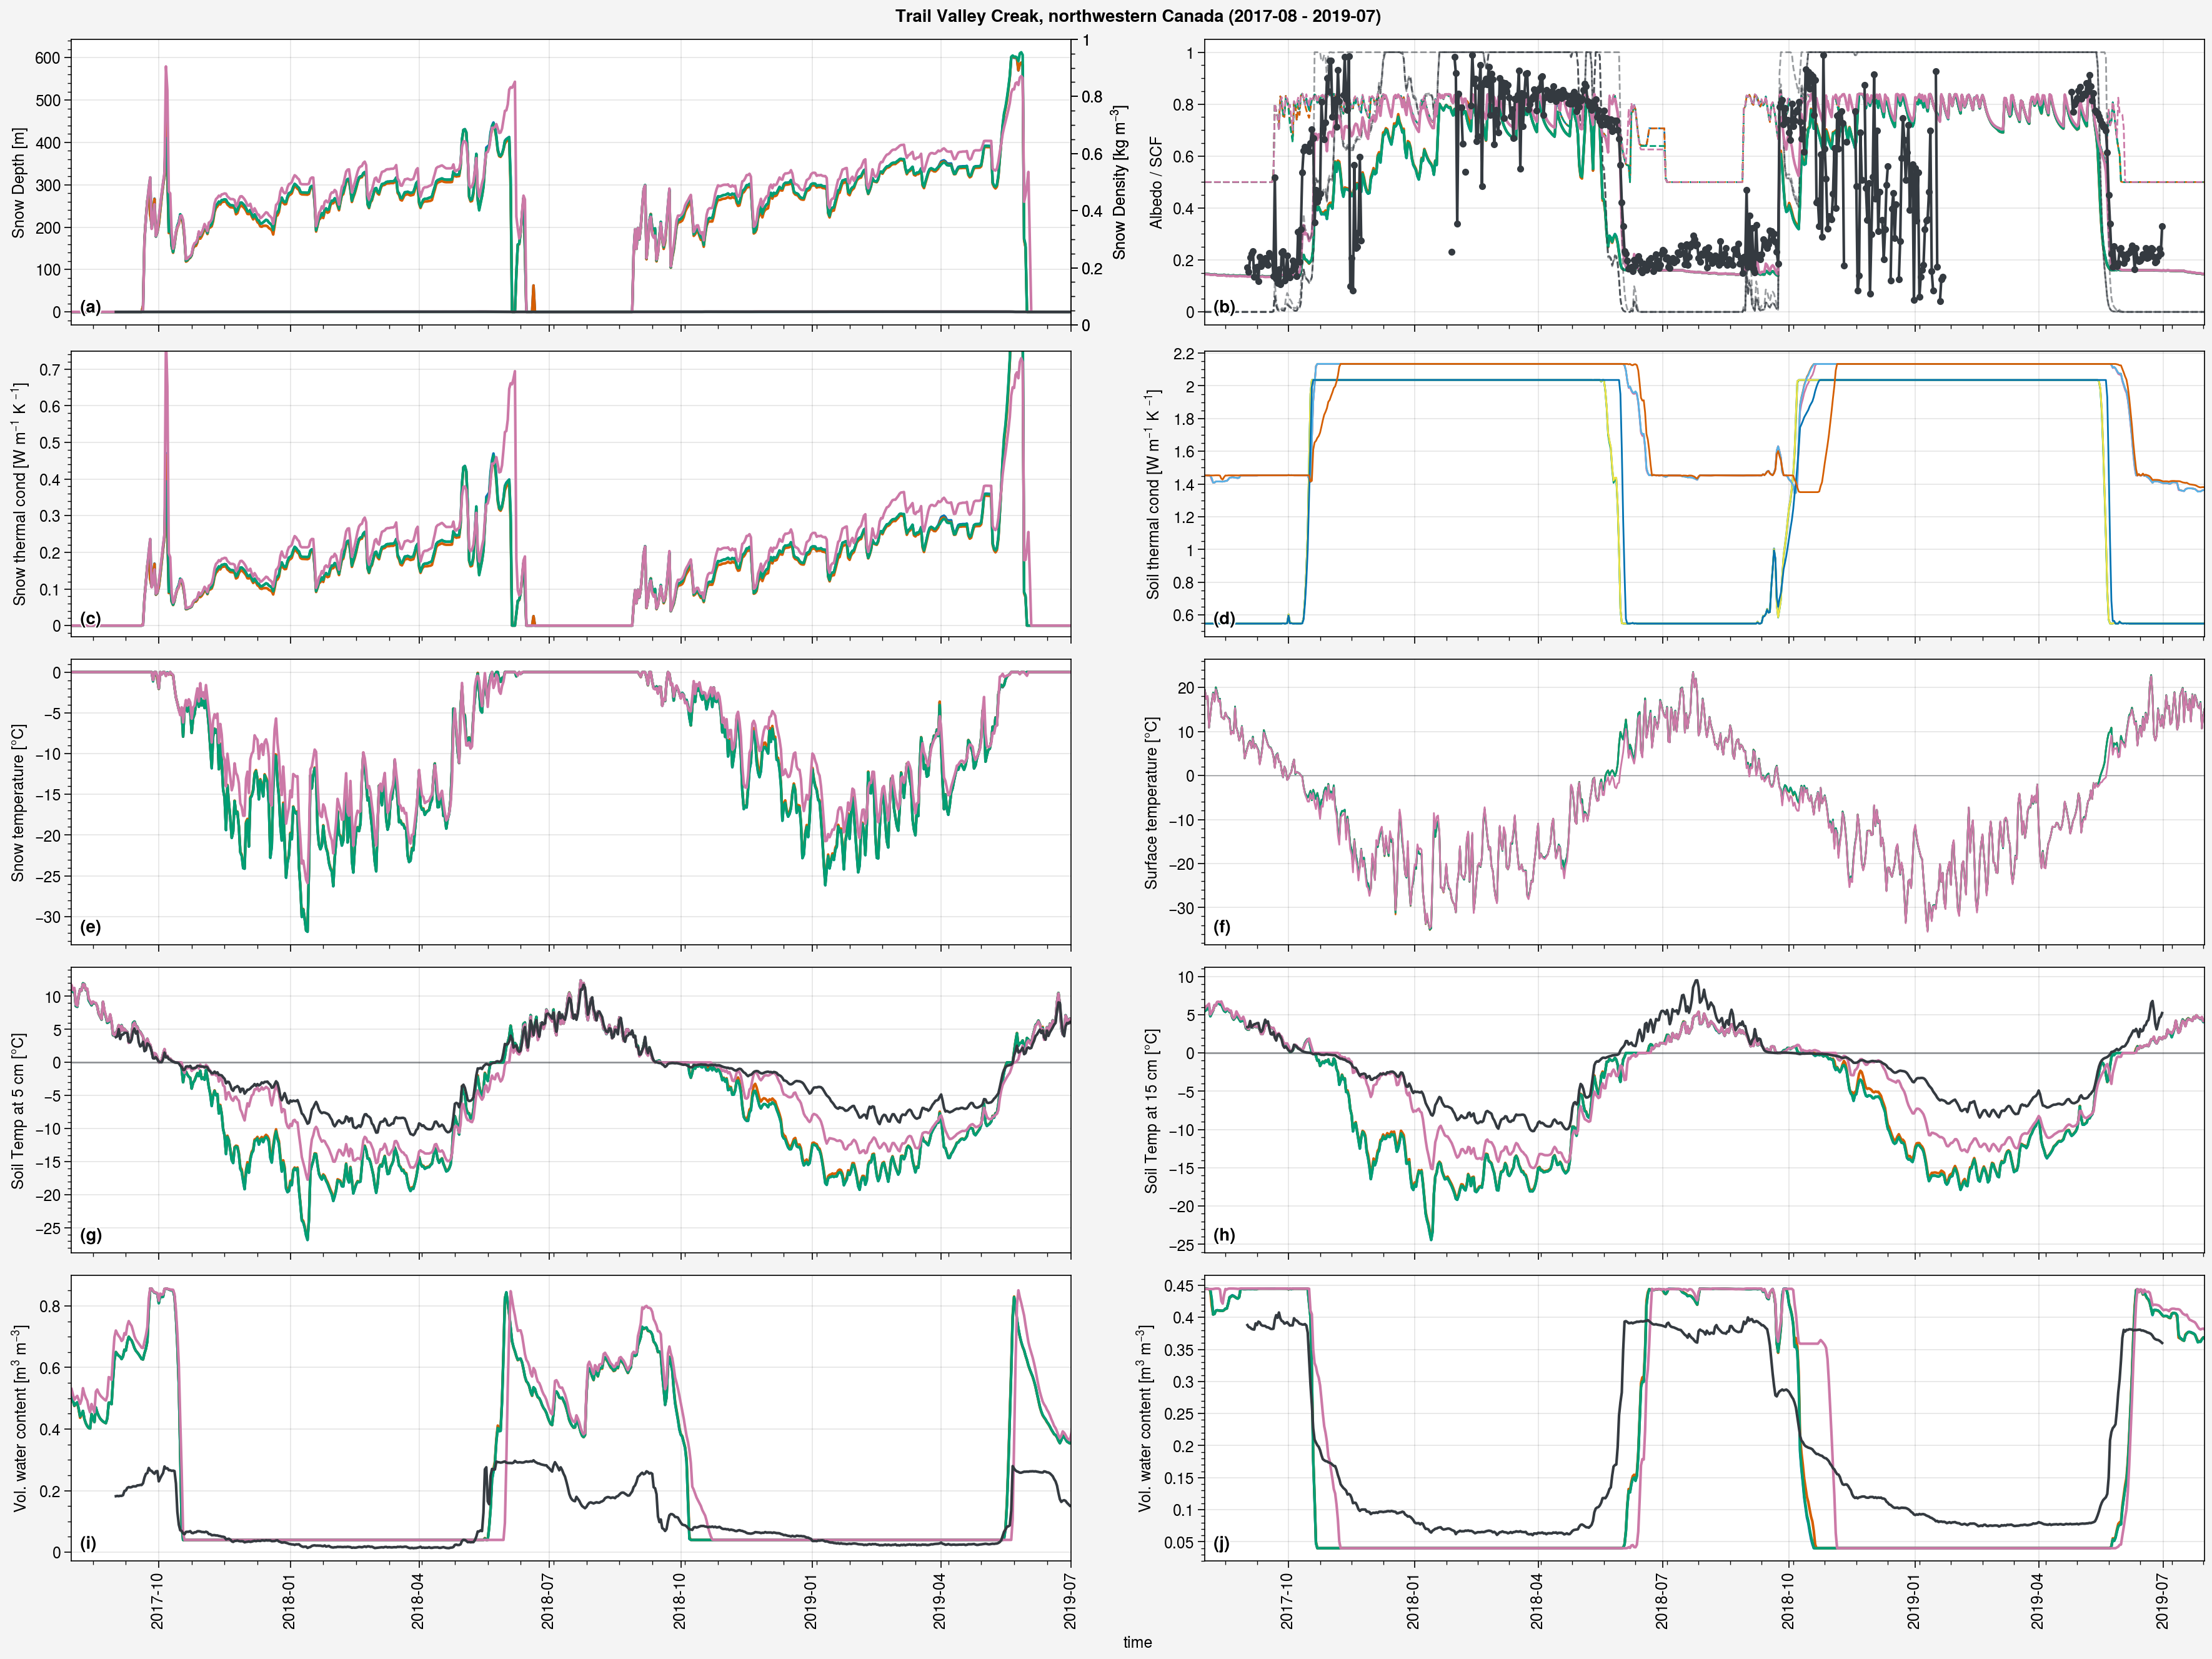

In [26]:
%matplotlib inline
color_obs = 'gray8'

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=8, sharey=0)
k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snd.sel(time=period), label=label)
    # axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)

ox = ax.alty(label='Snow Density [kg m$^{-3}$]')
i = 0
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snwdens.sel(time=period), label=label, c='C'+str(i))
    i += 1
        
# ox = ax.alty(label='Snow Cover Fraction')
# ox.line(ds_d.snc.sel(time=period), label='SCF', color='grey6', lw=0.8, ls='--')
# ox.legend(loc='ur')

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)')

# ax.legend(ncols=5, loc='ul')
ax.format(ylabel='Snow Depth [m]', 
          xlim=(pd.to_datetime(period.start), pd.to_datetime(period.stop)),
         )

k += 1
##################
### Albedo ###
##################
ax = axs[k]
i=0
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(i))
    ax.plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(i), ls='--', lw=1)
    ax.plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color=color_obs, alpha=0.5, ls='--', lw=1)
    i+=1
# Obs
ax.plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs, label='Surface albedo obs')

# ax.legend(loc='ul', ncols=4)
ax.format(ylabel='Albedo / SCF')


k += 1
##################
### Thermal cond in snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tcsnow.sel(time=period), label=label)
    
ax.format(
    ylabel='Snow thermal cond [W m$^{-1}$ K $^{-1}$]',
    xlim=(pd.to_datetime(period.start), pd.to_datetime(period.stop)),
    ylim=(-0.03, 0.75)
)
# ax.legend(ncols=5)


k += 1
##################
### Thermal cond soil ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tcbot.sel(layer=0.05, method='nearest').sel(time=period), label='Model (TCBOT_1)', lw=1)
    ax.plot(ds_d.tctop.sel(layer=0.15, method='nearest').sel(time=period), label='Model (TCTOP_2)', lw=1)


ax.format(
    ylabel='Soil thermal cond [W m$^{-1}$ K $^{-1}$]',
)
# ax.legend(ncols=5)


k += 1
##################
### T snow ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsn.sel(time=period), label=label)
    
# Obs
# ax.plot(ds_d_obs.tsn.sel(time=period), color=color_obs, label='Obs')

# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='Snow temperature [°C]')


k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1, zorder=2)

# Obs
# ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, label='Obs')
ax.hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c=color_obs, lw=0.5, alpha=0.5)

# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='Surface temperature [°C]')


k += 1
##################
### T soil ###
##################
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.05, method='nearest')-273.15, label=label+' (layer 1)')
    
# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.05, method='nearest'), color=color_obs, label='Obs (5 cm)')
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

k += 1
ax = axs[k]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
ax.plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.15, method='nearest'), color=color_obs, label='Obs (15 cm)')
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), color=color_obs, label='Obs (15 cm)')
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')

ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()

k += 1
##################
### SWC ###
##################
ax = axs[k]
sdepth = 0.05
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label+' (layer 1)')
    
# Obs
ax.plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs, label='Obs')

# ax.plot((ds_d_obs.mrsll.sel(time=period).sel(sdepth=[0.02, 0.05, 0.1], method='nearest').integrate('sdepth')/(0.1-0.02)), 
#             label='Obs (integral 0.02 to 0.1 m)', color=color_obs)

# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='Vol. water content [m$^3$ m$^{-3}$]')

k += 1
ax = axs[k]
sdepth = 0.15
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label+' (layer 2)')
    
# Obs
ax.plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs, label='Obs')
# ax.plot((ds_d_obs.mrsll.sel(time=period).sel(sdepth=[0.1, 0.15, 0.21], method='nearest').integrate('sdepth')/(0.21-0.1)), 
#             label='Obs (integral 0.1 to 0.21 m)', color=color_obs)

# ax.legend(loc='ul', ncols=2)
# fig.legend(loc='b', ncols=2)
ax.format(ylabel='Vol. water content [m$^3$ m$^{-3}$]')



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ll')

# fig.save('img/'+site+'_all_2014-2019.jpg')
# fig.save('img/'+site+'_all_2014-2019.pdf')

In [27]:
column_indexes = [['Obs'] + labels]

row_indexes = [['snd_auto', 'snwdens', 'tcsnow', 'ts', 'tsn', 'tsnbot', 'tsl_5', 'tsl_15'], ['ME', 'RMSE']]
rows = pd.MultiIndex.from_product(row_indexes)

df_metrics = pd.DataFrame(index=rows, columns=column_indexes)
df_metrics.loc[:, ('Obs', slice(None))] = 0
df_metrics

Obs 1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne  \
snd_auto ME     0                                         NaN   
         RMSE   0                                         NaN   
snwdens  ME     0                                         NaN   
         RMSE   0                                         NaN   
tcsnow   ME     0                                         NaN   
         RMSE   0                                         NaN   
ts       ME     0                                         NaN   
         RMSE   0                                         NaN   
tsn      ME     0                                         NaN   
         RMSE   0                                         NaN   
tsnbot   ME     0                                         NaN   
         RMSE   0                                         NaN   
tsl_5    ME     0                                         NaN   
         RMSE   0                                         NaN   
tsl_15   ME     0                                         NaN   
         RMSE   0                                         NaN   

              1peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne 1peat_Snowf  \
snd_auto ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
snwdens  ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
tcsnow   ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
ts       ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
tsn      ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
tsnbot   ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
tsl_5    ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   
tsl_15   ME                                         NaN         NaN   
         RMSE                                       NaN         NaN   

              1peat_2xSnowf  
snd_auto ME             NaN  
         RMSE           NaN  
snwdens  ME             NaN  
         RMSE           NaN  
tcsnow   ME             NaN  
         RMSE           NaN  
ts       ME             NaN  
         RMSE           NaN  
tsn      ME             NaN  
         RMSE           NaN  
tsnbot   ME             NaN  
         RMSE           NaN  
tsl_5    ME             NaN  
         RMSE           NaN  
tsl_15   ME             NaN  
         RMSE           NaN

In [28]:
# ds_d_obs = ds_d_obs.drop_vars('snwdens')
# ds_d_obs

In [29]:
ds_d_obs = ds_d_obs.assign({'snwdens': ('time', [np.nan]*ds_d_obs.time.size)})
ds_d_obs

<xarray.Dataset> Size: 118kB
Dimensions:           (time: 668, sdepth: 4)
Coordinates:
  * sdepth            (sdepth) float64 32B 0.02 0.05 0.1 0.2
  * time              (time) datetime64[ns] 5kB 2017-09-01 ... 2019-06-30
Data variables: (12/15)
    snd_auto          (time) float64 5kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tsl               (time, sdepth) float64 21kB 5.021 3.834 ... 5.732 4.72
    mrsll             (time, sdepth) float64 21kB 0.232 0.1819 ... 0.287 0.433
    SoilHEatFlux_org  (time) float64 5kB 6.104 11.39 9.86 1.357 ... nan nan nan
    SoilHEatFlux_min  (time) float64 5kB 5.848 12.86 11.75 7.613 ... nan nan nan
    NEE_filt          (time) float64 5kB -0.8253 0.1094 0.406 ... -2.071 -0.0614
    ...                ...
    LE_filled         (time) float64 5kB 22.29 16.89 21.12 ... 32.07 27.5 -1.015
    H_filled          (time) float64 5kB 17.54 12.97 17.06 ... 78.96 -12.94
    CH4_filt          (time) float64 5kB 0.001279 0.001616 0.002003 ... nan nan
    CH4_filled        (time) float64 5kB 0.001136 0.001072 ... 0.0002559
    albs              (time) float64 5kB 0.1721 0.1551 0.209 ... 0.225 0.331
    snwdens           (time) float64 5kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    location:    Trail Valley Creak
    ref:         https://doi.org/10.5194/tc-16-4201-2022
    soil_ref:    https://doi.pangaea.de/10.1594/PANGAEA.962726
    downloaded:  13/10/2024 by Mickaël Lalande
    merge:       TVCSnowCLM/TVCMetData/MSC_Snowdepth.csv and TVC_CLASSIC_2013...

In [30]:
ds_d_obs.snwdens.mean()

<xarray.DataArray 'snwdens' ()> Size: 8B
array(nan)

In [31]:
labels

['1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne',
 '1peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne',
 '1peat_Snowf',
 '1peat_2xSnowf']

In [32]:
df_metrics.columns.get_level_values(0)

Index(['Obs', '1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne',
       '1peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne', '1peat_Snowf',
       '1peat_2xSnowf'],
      dtype='object')

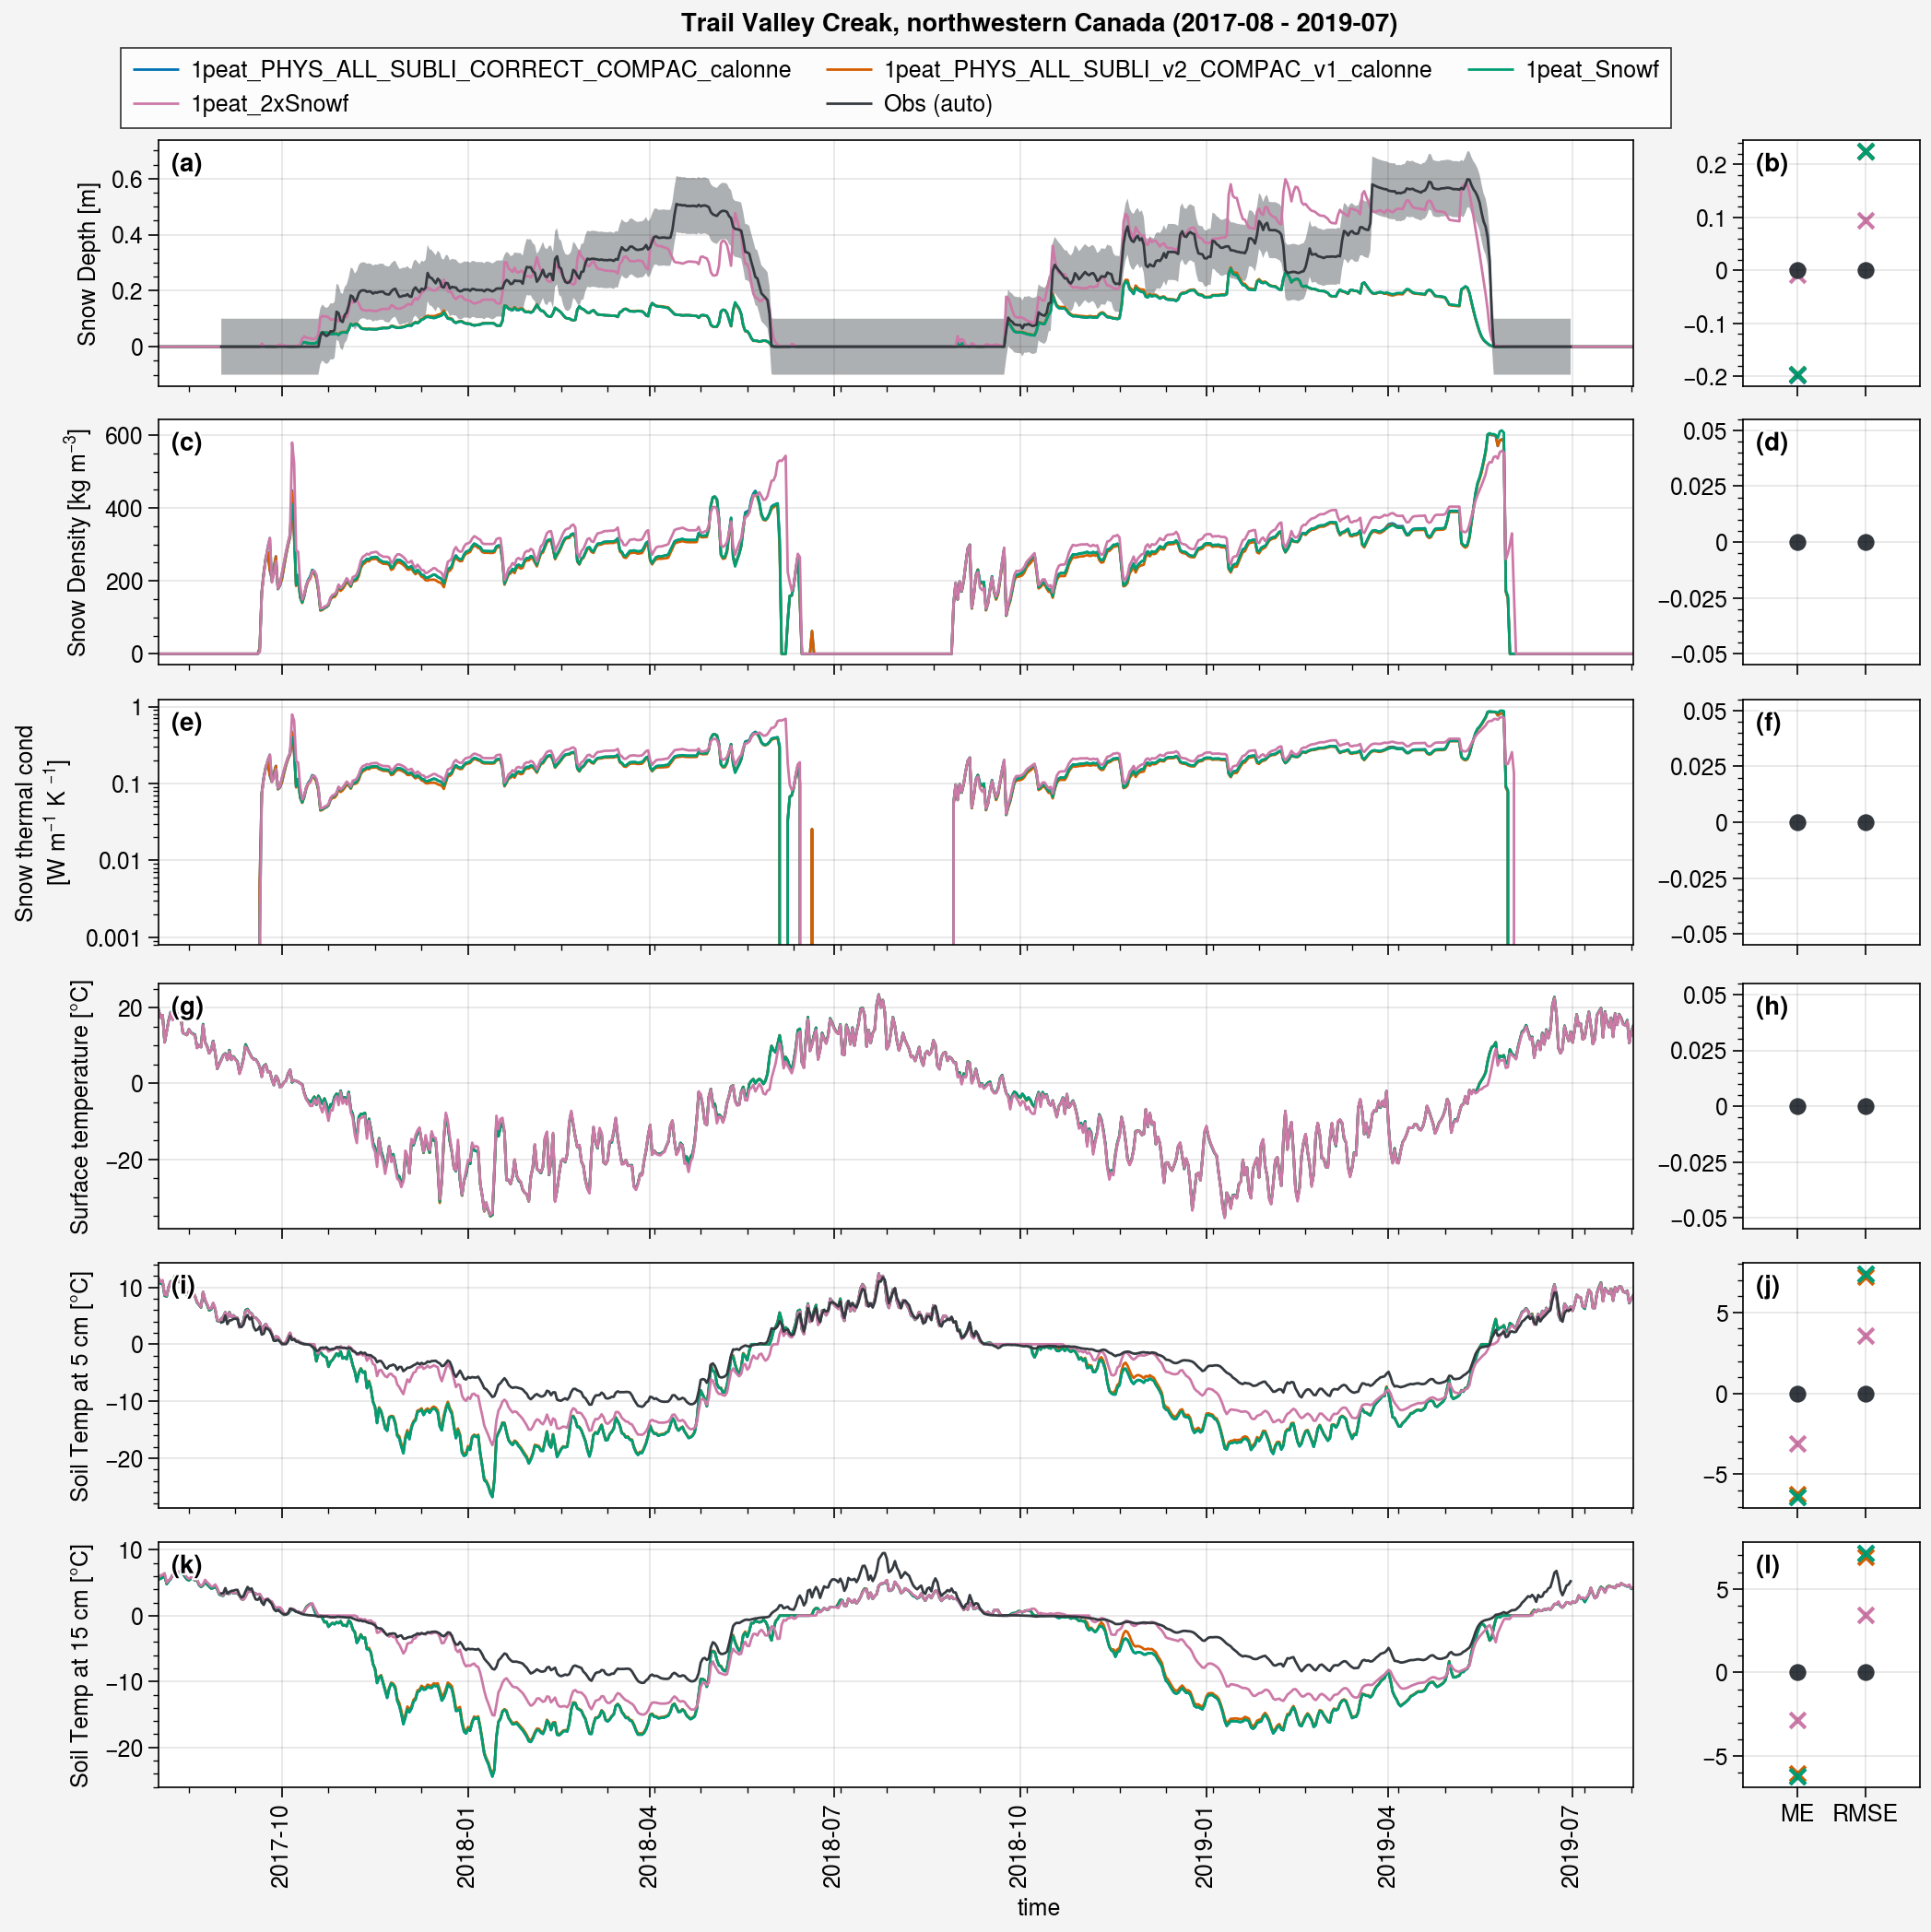

In [33]:
%matplotlib inline
color_obs = 'gray8'

mask_sd = ds_d_obs.snd_auto.sel(time=period) >= 0.1

# fig, axs = pplt.subplots(nrows=3, ncols=2, refaspect=3.5, sharey=0, figsize=(9,6))
# fig, axs = pplt.subplots(nrows=5, ncols=2, refaspect=3.5, refwidth=6, sharey=0)
fig, axs = pplt.subplots(nrows=6, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12))
# fig, axs = pplt.subplots(nrows=8, ncols=2, refaspect=6, refwidth=8, sharey=0, wratios=(1, 0.12), figsize=(9,14))

k = 0
##################
### Snow Depth ###
##################
ax = axs[k]
# Simus
for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
    if i < 6:
        ax.plot(ds_d.snd.sel(time=period), label=label, lw=1)
    else:
        ax.plot(ds_d.snd.sel(time=period), label=label, lw=1, ls='--', c='C0')

    df_metrics.loc[('snd_auto', 'RMSE'), label] = (xs.rmse(ds_d.snd.sel(time=period).where(mask_sd), 
                                                        ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values
    df_metrics.loc[('snd_auto', 'ME'), label] = (xs.me(ds_d.snd.sel(time=period).where(mask_sd), 
                                                      ds_d_obs.snd_auto.sel(time=period).where(mask_sd), skipna=True)).values


# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
    np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs, label='Obs (auto)', lw=1)
ax.format(ylabel='Snow Depth [m]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snd_auto'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
ax.scatter(df_metrics.loc[('snd_auto', 'Obs')], color=color_obs)
# ax.scatter(df_metrics.loc[('snd_auto', 'peat_TCZE_REF_TSNB_REF')], color='C0')
ax.format(xlim=(-0.8, 1.8))

 

k += 1
##################
### Snow dens ###
##################
ax = axs[k]

# Simus
for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
    if i < 6:
        ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1)
    else:
        ax.plot(ds_d.snwdens.sel(time=period), label=label, lw=1, ls='--', c='C0')
    # Get the snow density 15 days before the measurement ones because early snowmelt in the model leading to 
    # too high densities... (arbitrary, but more representative in my opinion)
    # df_metrics.loc[('snwdens', 'RMSE'), label] = (xs.rmse(ds_d.snwdens.sel(time=period).where(mask_sd).shift(time=30).rolling(time=30).mean(), 
    #                                                     ds_d_obs.snwdens.sel(time=period).where(mask_sd), skipna=True)).values
    # df_metrics.loc[('snwdens', 'ME'), label] = (xs.me(ds_d.snwdens.sel(time=period).where(mask_sd).shift(time=30).rolling(time=30).mean(), 
    #                                                   ds_d_obs.snwdens.sel(time=period).where(mask_sd), skipna=True)).values
    
# Obs
# ax.plot(ds_d_list[0].snwdens.sel(time=period).shift(time=15).where(ds_d_obs.snwdens.sel(time=period) > 0).shift(time=-15), 
#         color='C0', marker='x')
# ax.plot(ds_d_obs.snwdens.sel(time=period), color=color_obs, marker='o')
ax.format(ylabel='Snow Density [kg m$^{-3}$]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('snwdens'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
ax.scatter(df_metrics.loc[('snwdens', 'Obs')], color=color_obs)
# ax.scatter(df_metrics.loc[('snwdens', 'peat_TCZE_REF_TSNB_REF')], color='C0')


k += 1
##################
### Thermal cond in snow ###
##################
ax = axs[k]

for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
    ax.plot(ds_d.tcsnow.sel(time=period), label=label, lw=1)
    # df_metrics.loc[('tcsnow', 'RMSE'), label] = (xs.rmse(ds_d.tcsnow.sel(time=tcs_hmean.sel(time=period).time).where(mask_sd), 
    #                                                     tcs_hmean.sel(time=period).where(mask_sd), skipna=True)).values
    # df_metrics.loc[('tcsnow', 'ME'), label] = (xs.me(ds_d.tcsnow.sel(time=tcs_hmean.sel(time=period).time).where(mask_sd), 
    #                                                   tcs_hmean.sel(time=period).where(mask_sd), skipna=True)).values
    
# Obs
# ax.plot(tcs_hmean.sel(time=period), label='Obs (hmean)', color=color_obs, lw=1)
# ax.plot(ds_obs_tc.tcs.sel(time=period, sheight=0.02), label='Obs (2 cm)', lw=0.5)
# ax.plot(ds_obs_tc.tcs.sel(time=period, sheight=0.12), label='Obs (12 cm)', lw=0.5)
# ax.plot(ds_obs_tc.tcs.sel(time=period, sheight=0.22), label='Obs (22 cm)', lw=0.5)
ax.format(ylabel='Snow thermal cond\n[W m$^{-1}$ K $^{-1}$]', yscale='log')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tcsnow'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
ax.scatter(df_metrics.loc[('tcsnow', 'Obs')], color=color_obs)
# ax.scatter(df_metrics.loc[('snwdens', 'peat_TCZE_REF_TSNB_REF')], color='C0')


k += 1
##################
### T surf ###
##################
ax = axs[k]

# Simus
for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
    if i < 6:
        ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1)
    else:
        ax.plot(ds_d.ts.sel(time=period)-273.15, label=label, lw=1, ls='--', c='C0')
    # df_metrics.loc[('ts', 'RMSE'), label] = (xs.rmse(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
    #                                                     ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    # df_metrics.loc[('ts', 'ME'), label] = (xs.me(ds_d.ts.sel(time=period).where(mask_sd)-273.15, 
    #                                                   ds_d_obs.ts.sel(time=period).where(mask_sd), skipna=True)).values
    
# Obs
# ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs, lw=1)
ax.format(ylabel='Surface temperature [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('ts'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
ax.scatter(df_metrics.loc[('ts', 'Obs')], color=color_obs)
# ax.scatter(df_metrics.loc[('ts', 'peat_TCZE_REF_TSNB_REF')], color='C0')


# k += 1
# ##################
# ### T snow ###
# ##################
# ax = axs[k]

# # Simus
# for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
#     if i < 6:
#         ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1)
#     else:
#         ax.plot(ds_d.tsn.sel(time=period), label=label, lw=1, ls='--', c='C0')
#     # df_metrics.loc[('tsn', 'RMSE'), label] = (xs.rmse(ds_d.tsn.sel(time=period).where(mask_sd), 
#     #                                                     ds_d_obs.tsn.sel(time=period).where(mask_sd), skipna=True)).values
#     # df_metrics.loc[('tsn', 'ME'), label] = (xs.me(ds_d.tsn.sel(time=period).where(mask_sd), 
#     #                                                   ds_d_obs.tsn.sel(time=period).where(mask_sd), skipna=True)).values
    
# # Obs
# # ax.plot(ds_d_obs.tsn.sel(time=period), color=color_obs, lw=1)
# ax.format(ylabel='Snow temperature [°C]')

# k += 1
# ax = axs[k]
# ax.scatter(df_metrics.loc[('tsn'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
# ax.scatter(df_metrics.loc[('tsn', 'Obs')], color=color_obs)
# # ax.scatter(df_metrics.loc[('tsn', 'peat_TCZE_REF_TSNB_REF')], color='C0')


# k += 1
# ##################
# ### TSNBOT ###
# ##################
# ax = axs[k]

# # Simus
# for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
#     if i < 6:
#         ax.plot(ds_d.tsnbot.sel(time=period), label=label, lw=1)
#     else:
#         ax.plot(ds_d.tsnbot.sel(time=period), label=label, lw=1, ls='--', c='C0')
#     # df_metrics.loc[('tsnbot', 'RMSE'), label] = (xs.rmse(ds_d.tsnbot.sel(time=period).where(mask_sd), 
#     #                                                     TSNBOT_obs_day.sel(time=period).where(mask_sd), skipna=True)).values
#     # df_metrics.loc[('tsnbot', 'ME'), label] = (xs.me(ds_d.tsnbot.sel(time=period).where(mask_sd), 
#     #                                                   TSNBOT_obs_day.sel(time=period).where(mask_sd), skipna=True)).values
    
# # Obs
# # ax.plot(TSNBOT_obs_day.sel(time=period), color=color_obs, lw=1) 
# ax.format(ylabel='Bottom snow temp [°C]')

# k += 1
# ax = axs[k]
# ax.scatter(df_metrics.loc[('tsnbot'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
# ax.scatter(df_metrics.loc[('tsnbot', 'Obs')], color=color_obs)
# # ax.scatter(df_metrics.loc[('tsnbot', 'peat_TCZE_REF_TSNB_REF')], color='C0')


k += 1
##################
### T soil ###
##################
ax = axs[k]

# Simus
for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
    if i < 6:
        ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.05, method='nearest')-273.15, label=label, lw=1)
    else:
        ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.05, method='nearest')-273.15, label=label, lw=1, ls='--', c='C0')
    df_metrics.loc[('tsl_5', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period, layer=0.05).where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.05, method='nearest').where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_5', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period, layer=0.05).where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.05, method='nearest').where(mask_sd), skipna=True)).values
    
# Obs
ax.plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.05, method='nearest'), color=color_obs, label='Obs (5 cm)', lw=1)
ax.format(ylabel='Soil Temp at 5 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_5'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
ax.scatter(df_metrics.loc[('tsl_5', 'Obs')], color=color_obs)
# ax.scatter(df_metrics.loc[('tsl_5', 'peat_TCZE_REF_TSNB_REF')], color='C0')



k += 1
ax = axs[k]
# Simus
for i, (ds_d, label) in enumerate(zip(ds_d_list, labels)):
    if i < 6:
        ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label, lw=1)
    else:
        ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label, lw=1, ls='--', c='C0')
    df_metrics.loc[('tsl_15', 'RMSE'), label] = (xs.rmse(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest').where(mask_sd)-273.15, 
                                                        ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.15, method='nearest').where(mask_sd), skipna=True)).values
    df_metrics.loc[('tsl_15', 'ME'), label] = (xs.me(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest').where(mask_sd)-273.15, 
                                                      ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.15, method='nearest').where(mask_sd), skipna=True)).values
    
# Obs
ax.plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=0.15, method='nearest'), color=color_obs, label='Obs (15 cm)', lw=1)
ax.format(ylabel='Soil Temp at 15 cm [°C]')

k += 1
ax = axs[k]
ax.scatter(df_metrics.loc[('tsl_15'), df_metrics.columns.get_level_values(0)[1:]], marker='x')
ax.scatter(df_metrics.loc[('tsl_15', 'Obs')], color=color_obs)
# ax.scatter(df_metrics.loc[('tsl_15', 'peat_TCZE_REF_TSNB_REF')], color='C0')




# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period, layer=0.05)-273.15, label=label+' (layer 1)')
    
# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.05)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.05), shadedata=shadedata, color=color_obs, label='Obs (5 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.02, 0.05, 0.1]).integrate('sdepth')/(0.1-0.02), color='red')

# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 5 cm [°C]')
# ax.legend()

# k += 1
# ax = axs[k]
# # Simus
# for ds_d, label in zip(ds_d_list, labels):
#     ax.plot(ds_d.tsl.sel(time=period).sel(layer=0.15, method='nearest')-273.15, label=label+' (layer 2)')

# # Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=0.15)-1, axis=0),), axis=0)
# ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=0.15), shadedata=shadedata, color=color_obs, label='Obs (15 cm)')
# # ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=[0.1, 0.15, 0.21]).integrate('sdepth')/(0.21-0.1), color='red')


# ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c=color_obs, lw=1, alpha=0.5)
# ax.format(ylabel='Soil Temp at 15 cm [°C]')
# ax.legend()



fig.suptitle(site_longname + ' ('+period.start+' - '+period.stop+')')
fig.format(abc='(a)', abcloc='ul')
axs[0].legend(ncols=3, loc='t')


# fig.save('img/'+site+'_peat_mtr_phys_2014-2019.jpg')
# fig.save('img/'+site+'_peat_mtr_opti_COMPACT_2014-2019.jpg')
# fig.save('img/'+site+'_1peat_mtr_opti_COMPACT_calonne_2017-2019_Snowf.jpg')
# fig.save('img/'+site+'_1peat_mtr_opti_COMPACT_calonne_2017-2019_Snowf.pdf')

In [34]:
df_metrics

Obs 1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne  \
snd_auto ME     0                         -0.1971107738183599   
         RMSE   0                          0.2243756242194905   
snwdens  ME     0                                         NaN   
         RMSE   0                                         NaN   
tcsnow   ME     0                                         NaN   
         RMSE   0                                         NaN   
ts       ME     0                                         NaN   
         RMSE   0                                         NaN   
tsn      ME     0                                         NaN   
         RMSE   0                                         NaN   
tsnbot   ME     0                                         NaN   
         RMSE   0                                         NaN   
tsl_5    ME     0                           -6.40779711589919   
         RMSE   0                          7.4066767174214405   
tsl_15   ME     0                          -6.227991078889304   
         RMSE   0                           7.139834790069313   

              1peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne           1peat_Snowf  \
snd_auto ME                        -0.19596614110434127  -0.19692726001231234   
         RMSE                       0.22389295732011416   0.22412853087086118   
snwdens  ME                                         NaN                   NaN   
         RMSE                                       NaN                   NaN   
tcsnow   ME                                         NaN                   NaN   
         RMSE                                       NaN                   NaN   
ts       ME                                         NaN                   NaN   
         RMSE                                       NaN                   NaN   
tsn      ME                                         NaN                   NaN   
         RMSE                                       NaN                   NaN   
tsnbot   ME                                         NaN                   NaN   
         RMSE                                       NaN                   NaN   
tsl_5    ME                          -6.218973881204612    -6.407004140247023   
         RMSE                        7.2106602980657595     7.404657824656494   
tsl_15   ME                          -6.026734006098113    -6.227120998913567   
         RMSE                         6.933638993429146     7.137972517030533   

                       1peat_2xSnowf  
snd_auto ME    -0.009010769776061226  
         RMSE    0.09392930165795642  
snwdens  ME                      NaN  
         RMSE                    NaN  
tcsnow   ME                      NaN  
         RMSE                    NaN  
ts       ME                      NaN  
         RMSE                    NaN  
tsn      ME                      NaN  
         RMSE                    NaN  
tsnbot   ME                      NaN  
         RMSE                    NaN  
tsl_5    ME      -3.1129932427342477  
         RMSE      3.592165080773919  
tsl_15   ME       -2.834413119800617  
         RMSE      3.424692971308414